# Final Exam 

## Portfolio Construction using Black-Litterman Model and Factors

### Kieran Fitzpatrick

# 1. Introduction

In this paper, we aimed to construct and optimize a portfolio that effectively balances risk and return, using a comprehensive approach that integrates modern portfolio theory with the Black-Litterman model. We began by selecting a benchmark portfolio, carefully choosing assets that represent a diverse mix of equities, bonds, and other financial instruments. Our initial analysis included applying the Fama-French three-factor model and examining momentum factors, which informed our market views and were critical to our Black-Litterman model. By incorporating these views into the model, we adjusted our expected returns to better reflect our market expectations. Following this, we employed various optimization techniques, including Mean-Variance Optimization (MVO), to create portfolios that target specific risk levels while maximizing returns. Finally, through backtesting, we demonstrated that our optimized portfolio strategy not only outperformed the benchmark but did so without taking on additional risk, validating the effectiveness of our approach. This is most closley related to Option A in the Q&A doc.

In [113]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import datetime as dt
from numpy.linalg import inv
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import statsmodels.api as sm
import copy
import cvxpy as cp
import zipfile
import io
import requests

## 2. Methodology

Before introducing the methodology and formula, let us introduce some of the notations in our paper.

We aim to include 17 factors/assets in our portfolio construction, each one is represented by a ETF or a fund. Plus, there is one benchmark, SPDR SSgA Global Allocation ETF and one risk-free return which is captured by the Treasury Bill rate. So, there are 19 assets being introduced, and each is a time series. We would use those 17 factors, 1 benchmark, and 1 risk-free rate to construct our portfolio.

- $w$: a vector of weights.
- $\mu$: a vector of the expected return for each factor.
- $\Sigma$: a variance-covariance matrix for factors.
- $\mathbf{1}$: a one vector, with all elements being 1.
- The superscript $\{T\}$ means the transpose of a vector or a matrix. The superscript $\{-1\}$ means the inverse of a matrix.
- Matrix are mostly $N \times N$, where $N$ is the number of factors ($N = 17$ in our case). However, views of the Black-Litterman model is a $K \times N$ matrix, where $K$ is the number of views, and $N$ is the number of factors, $N = 17$ in our paper as there are 17 factors. Views are one-hot encoding.


# 3. Factor Selection

## 3.1 Benchmark/Assets Selection
The SPDR SSgA Global Allocation ETF is an ideal benchmark for this portfolio construction exercise due to its broad global diversification and multi-asset exposure. As a proxy for the world market portfolio, it includes a variety of asset classes such as U.S. equities (e.g., SPDR S&P 500 ETF Trust), developed and emerging market stocks (e.g., SPDR Portfolio Developed World and Emerging Markets ETFs), and bonds (e.g., SPDR Portfolio Aggregate Bond ETF). This comprehensive market representation makes it a robust standard for comparing the performance of a diversified, factor-based portfolio, particularly when applying advanced techniques like the Black-Litterman model.

To construct our portfolio, we focus on three main rationales:

First, we adopt a global perspective by including both U.S. and Global Markets, both developed and emerging. The U.S. represents the largest financial market, while a Global market component is key to express views in certain regions if suitable.

Second, we diversify across asset classes  inluding bonds, equities, cash and credit to capture a wide range of market movements and mitigate risk. This includes U.S. and International bonds and equities.

Third, we incorporate factors such as growth, value, size, market cap, and industry-specific factors for both U.S. and Global equities. These factors, supported by empirical research, are crucial in capturing market dynamics.

The benchamrk has a well-diversified asset allocation, with approximately 60% in global equities and 35% in bonds. The remaining 5% is split between commodities and cash equivalents. The equity portion covers a range of sectors globally, including technology (around 20%), financials (15%), and healthcare (10%). The fixed-income allocation includes both U.S. and international bonds, providing exposure to various credit qualities and maturities. This mix offers a balanced blend of growth potential and income generation, making it a robust global market proxy. Also, the breakdown of weights is provided online which will be used for the equilibrium wights when conducting our Black Litterman analysis.

In summary, we selected 17 factors/assets along with a benchmark and a risk-free rate, ensuring low correlation for better diversification and analysis. 

## 3.2 Factor/Style Analysis Overview

Factor and style analysis in investing involve examining the key drivers of returns in a portfolio, beyond traditional market factors (CAPM). These analyses help investors understand and potentially exploit systematic risks for better portfolio construction.

Factor and style analysis expand on the traditional Capital Asset Pricing Model (CAPM) by considering additional systematic risk factors that influence stock returns. The Fama-French 3-Factor Model (1993) includes the market risk premium plus size (SMB, Small Minus Big) and value (HML, High Minus Low) factors, improving upon CAPM by better explaining returns, particularly for small-cap and value stocks. The 5-Factor Model (2015) further incorporates profitability (RMW, Robust Minus Weak) and investment (CMA, Conservative Minus Aggressive) factors, offering a more comprehensive framework. These models are significant because they capture broader dimensions of risk and return that CAPM overlooks, making them more effective for portfolio construction.

**Fama-French 3-Factor Model:**

$$
R_i - R_f = \alpha + \beta_m (R_m - R_f) + \beta_{SMB} \times SMB + \beta_{HML} \times HML + \epsilon
$$

Where :
- $R_f$: Risk-free rate
- $R_m$: Market return
- $\alpha$: Asset's alpha (excess return)
- $\beta_m$: Sensitivity to the market risk premium
- $\beta_{SMB}$: Sensitivity to the size factor (SMB)
- $\beta_{HML}$: Sensitivity to the value factor (HML)

- $\epsilon$: Error term (unsystematic risk)


As an example, the Fama-French 3 factor model consists of 3 independent variables - the market premium or the returns of the market portfolio (represented by an index like the S&P 500), the size premium or the returns of a portfolio of small companies (theoretically on average small companies have higher returns that big companies) and the value premium or the returns of companies with high book-to-market ratio (called value stocks) over companies with low book to market ratio and the asset returns as the dependet variable in model. Thus, the Fama-French model provides a way to measure risk-adjusted asset returns by accounting for three major market factors that influence asset returns. As mentioned before new factors have cropped up in recent years but this paper will focus on the well researched and evidenced Fama French Factors.



## 4. Data

All the data we use in this paper are extracted from Yahoo!Finance. The Benchmark is SPDR SSGA Global Allocation ETF which is a global multi-asset fund ideal for our analysis. The fund invests in exchange traded funds which are provided below and the weightings are shared by the fund. One point to note was that SPDR BLOOMBERG EMERGING MARKET(emerging market bond fund) data was unavialble for some dates on Yahoo Finance. We have replaced it with the similar asset iShares J.P. Morgan USD Emerging Markets Bond ETF and maintained the weighting provided by the benchmark.

In [114]:
# Define the ticker symbols for the assets
tickers = {
    "SPDR S&P 500 ETF TRUST": "SPY",
    "SPDR PORTFOLIO DEVELOPED WORLD": "SPDW",
    "SPDR PORTFOLIO EMERGING MARKET": "SPEM",
    "SPDR PORTFOLIO AGGREGATE BOND": "SPAB",
    "SSI US GOV MONEY MARKET CLASS" :"0P0000JTHS",
    "SPDR BLOOMBERG HIGH YIELD BOND": "JNK",
    "SPDR PORTFOLIO S&P 600 SMALL C": "SPSM",
    "SPDR BLOOMBERG 1 10 YEAR TIPS": "TIPX",
    "SPDR BLOOMBERG INTERNATIONAL C": "IBND",
    "iShares J.P. Morgan USD Emerging Markets Bond ETF": "EMB",
    "SPDR S&P INTERNATIONAL SMALL C": "GWX",
    "COMMUNICATION SERVICES SELECT": "XLC",
    "ENERGY SELECT SECTOR SPDR FUND": "XLE",
    "SPDR S&P MIDCAP 400 ETF TRUST": "MDY",
    "TECHNOLOGY SELECT SECTOR SPDR": "XLK",
    #"SPDR BLOOMBERG EMERGING MARKET": "EMHC",
    "SPDR BLACKSTONE SENIOR LOAN ET": "SRLN",
    "SPDR BLOOMBERG INTERNATIONAL T": "BWX",
    "SPDR PORTFOLIO LONG TERM TREAS": "SPTL",
    "Risk Free Rate": "^IRX", #Risk-Free Rate
    "SPDR SSgA Global Allocation (Benchmark)": "GAL" #Benchmark
}

# Define the start and end date for the 5-year period
start_date = "2019-06-30"
end_date = "2024-06-30"

# Download the historical data for indices and store in a pandas DataFrame
data = pd.DataFrame({name: yf.download(ticker, start=start_date, end=end_date)['Adj Close']
                     for name, ticker in tickers.items() if ticker != "-"})

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [115]:

# Load the assets from Yahoo Finance
fund_data = pd.DataFrame()

# Loop through the ticker dictionary
for name, ticker in tickers.items():
    if ticker != "-":  # Ensure the ticker is valid
        fund = yf.Ticker(ticker)
        info = fund.info
        category = info.get('category', 'N/A')
        aum = info.get('totalAssets', 'N/A')       
        history = fund.history(start=start_date, end=end_date)
        adj_close = history['Close'].dropna()

        # Add information to DataFrame
        fund_data = fund_data.append({
            'Name': name,
            'Ticker': ticker,
            'Category': category,
            'AUM': aum,
                    }, ignore_index=True)

# Set column order and print the DataFrame
fund_data = fund_data[['Name', 'Ticker', 'Category', 'AUM']]

fund_data


,Name,Ticker,Category,AUM
0,SPDR S&P 500 ETF TRUST,SPY,Large Blend,562499813376.0
1,SPDR PORTFOLIO DEVELOPED WORLD,SPDW,Foreign Large Blend,20938168320.0
2,SPDR PORTFOLIO EMERGING MARKET,SPEM,Diversified Emerging Mkts,9134830592.0
3,SPDR PORTFOLIO AGGREGATE BOND,SPAB,Intermediate Core Bond,8113986560.0
4,SSI US GOV MONEY MARKET CLASS,0P0000JTHS,N/A,N/A
5,SPDR BLOOMBERG HIGH YIELD BOND,JNK,High Yield Bond,8562563072
6,SPDR PORTFOLIO S&P 600 SMALL C,SPSM,Small Blend,11586173952
7,SPDR BLOOMBERG 1 10 YEAR TIPS,TIPX,Short-Term Inflation-Protected Bond,1366132864
8,SPDR BLOOMBERG INTERNATIONAL C,IBND,Global Bond,158967696
9,iShares J.P. Morgan USD Emerging Markets Bond ETF,EMB,Emerging Markets Bond,15228625920


In [116]:
# drop the "Risk Free Rate" and "SPDR SSgA Global Allocation (Benchmark)" 
prices = data.drop(columns=["Risk Free Rate"])

In [117]:
# Calculate the percentage change 
returns = prices.pct_change()

returns = returns.dropna()

<AxesSubplot:xlabel='Date'>

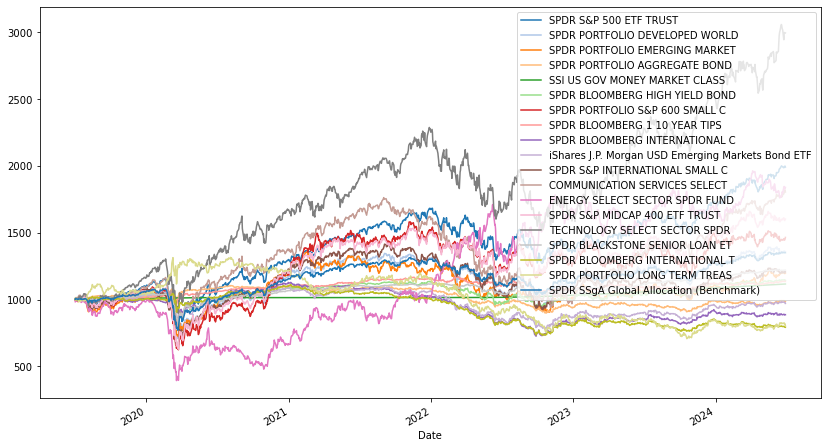

In [118]:
#Calculate the cumulative returns
cumulative_returns = (1 + returns).cumprod()

#Calculate the cumulative growth of an initial investment of $1,000
initial_investment = 1000
cumulative_value = cumulative_returns * initial_investment

cumulative_value.plot(figsize=(14, 8))

In [119]:
# Generate summary statistics for the returns DataFrame
summary_stats = returns.describe()

# Display the summary statistics
summary_stats


,SPDR S&P 500 ETF TRUST,SPDR PORTFOLIO DEVELOPED WORLD,SPDR PORTFOLIO EMERGING MARKET,SPDR PORTFOLIO AGGREGATE BOND,SSI US GOV MONEY MARKET CLASS,SPDR BLOOMBERG HIGH YIELD BOND,SPDR PORTFOLIO S&P 600 SMALL C,SPDR BLOOMBERG 1 10 YEAR TIPS,SPDR BLOOMBERG INTERNATIONAL C,iShares J.P. Morgan USD Emerging Markets Bond ETF,SPDR S&P INTERNATIONAL SMALL C,COMMUNICATION SERVICES SELECT,ENERGY SELECT SECTOR SPDR FUND,SPDR S&P MIDCAP 400 ETF TRUST,TECHNOLOGY SELECT SECTOR SPDR,SPDR BLACKSTONE SENIOR LOAN ET,SPDR BLOOMBERG INTERNATIONAL T,SPDR PORTFOLIO LONG TERM TREAS,SPDR SSgA Global Allocation (Benchmark)
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,0.000635,0.000323,0.000228,-0.000001,0.000088,0.000129,0.000451,0.000107,-0.000076,0.000009,0.000232,0.000587,0.000751,0.000503,0.001021,0.000172,-0.000164,-0.000117,0.000275
std,0.013157,0.012481,0.012910,0.004399,0.000119,0.006634,0.017092,0.003254,0.006195,0.007968,0.012700,0.015306,0.022949,0.015936,0.017214,0.005139,0.006223,0.010586,0.008397
min,-0.109424,-0.111902,-0.113644,-0.060394,-0.000549,-0.057572,-0.133621,-0.021363,-0.034572,-0.092159,-0.121672,-0.112795,-0.201412,-0.136491,-0.138140,-0.059223,-0.053113,-0.061342,-0.078735
25%,-0.004979,-0.005517,-0.005965,-0.001986,0.000000,-0.002189,-0.008366,-0.001422,-0.003272,-0.003106,-0.005773,-0.006818,-0.010091,-0.007053,-0.008001,-0.000728,-0.003168,-0.006603,-0.003577
50%,0.000842,0.000806,0.000375,0.000000,0.000053,0.000223,0.000453,0.000000,-0.000271,0.000351,0.000569,0.001074,0.000768,0.000667,0.001397,0.000239,-0.000318,0.000000,0.000491
75%,0.007270,0.006644,0.007064,0.002017,0.000145,0.002626,0.009536,0.001607,0.003388,0.003476,0.007030,0.008409,0.011539,0.008900,0.010341,0.001428,0.003089,0.006035,0.004666
max,0.090603,0.089329,0.075652,0.043944,0.000601,0.067086,0.092299,0.028327,0.035659,0.045961,0.080554,0.089901,0.160373,0.110663,0.117319,0.041580,0.037861,0.071898,0.060424


We will conduct a factor analysis of the underlying assets within the SPDR SSgA Global Allocation ETF (Benchmark) to identify the specific factors and styles to which these assets are exposed. This analysis will help us understand the risk drivers within the portfolio, such as size, value, and momentum factors. The insights gained will be crucial in forming our investment views, which we will later incorporate into the Black-Litterman model to optimize our asset allocation strategy.

The next section begins with an import of the fama-french 3-factor model variables: excess return on the market, the size of firms and the book-to-market values.

## 4.1 Historical Excess Return

In [120]:
# Calculate cumulative returns and annualized returns in one step
annualized_returns = ((1 + returns).cumprod().iloc[-1]) ** (252 / len(returns)) - 1
# Convert the results to a DataFrame 
annualized_returns_df = annualized_returns.to_frame(name='Annualized Return')
annualized_returns_df

,Annualized Return
SPDR S&P 500 ETF TRUST,0.148101
SPDR PORTFOLIO DEVELOPED WORLD,0.063412
SPDR PORTFOLIO EMERGING MARKET,0.036934
SPDR PORTFOLIO AGGREGATE BOND,-0.002814
SSI US GOV MONEY MARKET CLASS,0.022422
SPDR BLOOMBERG HIGH YIELD BOND,0.027401
SPDR PORTFOLIO S&P 600 SMALL C,0.079630
SPDR BLOOMBERG 1 10 YEAR TIPS,0.026042
SPDR BLOOMBERG INTERNATIONAL C,-0.023633
iShares J.P. Morgan USD Emerging Markets Bond ETF,-0.005755


##### Daily Risk-free Rate

In [121]:
# Extract the annualized risk-free rate (assuming it's in percentage)
annualized_risk_free_rate = data['Risk Free Rate']/ 100

# Calculate the daily risk-free rate
daily_risk_free_rate = (1 + annualized_risk_free_rate) ** (1/252) - 1

daily_risk_free_rate

Date
2019-07-01    0.000081
2019-07-02    0.000084
2019-07-03    0.000084
2019-07-05    0.000085
2019-07-08    0.000086
                ...   
2024-06-24    0.000202
2024-06-25    0.000202
2024-06-26    0.000202
2024-06-27    0.000202
2024-06-28    0.000202
Name: Risk Free Rate, Length: 1258, dtype: float64

In [122]:
# Calculate the daily excess returns
historical_excess_returns = returns.sub(daily_risk_free_rate, axis=0).dropna()
historical_excess_returns.head()

,SPDR S&P 500 ETF TRUST,SPDR PORTFOLIO DEVELOPED WORLD,SPDR PORTFOLIO EMERGING MARKET,SPDR PORTFOLIO AGGREGATE BOND,SSI US GOV MONEY MARKET CLASS,SPDR BLOOMBERG HIGH YIELD BOND,SPDR PORTFOLIO S&P 600 SMALL C,SPDR BLOOMBERG 1 10 YEAR TIPS,SPDR BLOOMBERG INTERNATIONAL C,iShares J.P. Morgan USD Emerging Markets Bond ETF,SPDR S&P INTERNATIONAL SMALL C,COMMUNICATION SERVICES SELECT,ENERGY SELECT SECTOR SPDR FUND,SPDR S&P MIDCAP 400 ETF TRUST,TECHNOLOGY SELECT SECTOR SPDR,SPDR BLACKSTONE SENIOR LOAN ET,SPDR BLOOMBERG INTERNATIONAL T,SPDR PORTFOLIO LONG TERM TREAS,SPDR SSgA Global Allocation (Benchmark)
Date,,,,,,,,,,,,,,,,,,,
2019-07-02,0.002520,0.002942,-0.004215,0.001979,-0.000022,0.001853,-0.003988,0.000429,0.002267,0.001679,0.005226,0.009186,-0.016079,-0.002674,0.002564,-0.000301,0.001308,0.006749,0.003559
2019-07-03,0.007911,0.004944,0.002404,0.001973,0.000041,0.003414,0.006774,0.001456,-0.000084,0.002644,0.004207,0.005107,0.003900,0.008974,0.007590,-0.000302,0.004782,0.006441,0.005360
2019-07-05,-0.001223,-0.007090,-0.006979,-0.003851,0.000103,-0.003754,0.003808,-0.003160,-0.001844,-0.005263,-0.003372,0.001305,0.001344,0.000810,-0.001958,0.000133,-0.008041,-0.011755,-0.003437
2019-07-08,-0.005581,-0.006468,-0.005362,-0.000773,-0.000014,-0.001743,-0.010102,-0.000600,-0.005375,-0.001497,-0.010969,-0.009012,0.001341,-0.009558,-0.007715,0.000348,-0.001480,0.000964,-0.003449
2019-07-09,0.001161,-0.003805,-0.001482,-0.000086,-0.000023,-0.001378,0.000567,-0.000086,0.000209,-0.002472,-0.007422,0.006119,0.000705,0.000111,0.003443,-0.001171,-0.002530,-0.000348,-0.002423


In [123]:
# Annualize the daily excess returns
historical_annualized_excess_returns = (1 + historical_excess_returns).prod() ** (252 / len(historical_excess_returns)) - 1

historical_annualized_excess_returns

SPDR S&P 500 ETF TRUST                               0.123976
SPDR PORTFOLIO DEVELOPED WORLD                       0.041060
SPDR PORTFOLIO EMERGING MARKET                       0.015137
SPDR PORTFOLIO AGGREGATE BOND                       -0.023779
SSI US GOV MONEY MARKET CLASS                        0.000929
SPDR BLOOMBERG HIGH YIELD BOND                       0.005804
SPDR PORTFOLIO S&P 600 SMALL C                       0.056933
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.004470
SPDR BLOOMBERG INTERNATIONAL C                      -0.044160
iShares J.P. Morgan USD Emerging Markets Bond ETF   -0.026656
SPDR S&P INTERNATIONAL SMALL C                       0.016929
COMMUNICATION SERVICES SELECT                        0.102030
ENERGY SELECT SECTOR SPDR FUND                       0.106217
SPDR S&P MIDCAP 400 ETF TRUST                        0.076034
TECHNOLOGY SELECT SECTOR SPDR                        0.219769
SPDR BLACKSTONE SENIOR LOAN ET                       0.018932
SPDR BLO

In [124]:
daily_market_returns = data['SPDR SSgA Global Allocation (Benchmark)'].pct_change().dropna() #Benchamrk returns
market_prices = data['SPDR SSgA Global Allocation (Benchmark)']
daily_excess_market_returns = daily_market_returns.sub(daily_risk_free_rate, axis=0).dropna()
daily_market_returns

Date
2019-07-02    0.003643
2019-07-03    0.005444
2019-07-05   -0.003352
2019-07-08   -0.003364
2019-07-09   -0.002337
                ...   
2024-06-24    0.002289
2024-06-25    0.000185
2024-06-26   -0.002078
2024-06-27   -0.000231
2024-06-28    0.000463
Name: SPDR SSgA Global Allocation (Benchmark), Length: 1257, dtype: float64

In [125]:
annualized_market_returns = (1 + daily_market_returns).prod() ** (252 / len(daily_market_returns)) - 1
annualized_market_returns

0.06218272964735472

In [126]:
historical_annualized_excess_market_returns = (1 + daily_excess_market_returns).prod() ** (252 / len(daily_excess_market_returns)) - 1 #Annaulised Excess Benchmark/Market Returns
historical_annualized_excess_market_returns

0.039856293307243496

In [127]:
historical_excess_returns_vol =  historical_excess_returns.std() #volatility

historical_excess_returns_vol

SPDR S&P 500 ETF TRUST                               0.013157
SPDR PORTFOLIO DEVELOPED WORLD                       0.012481
SPDR PORTFOLIO EMERGING MARKET                       0.012909
SPDR PORTFOLIO AGGREGATE BOND                        0.004398
SSI US GOV MONEY MARKET CLASS                        0.000080
SPDR BLOOMBERG HIGH YIELD BOND                       0.006633
SPDR PORTFOLIO S&P 600 SMALL C                       0.017094
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.003256
SPDR BLOOMBERG INTERNATIONAL C                       0.006192
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.007966
SPDR S&P INTERNATIONAL SMALL C                       0.012700
COMMUNICATION SERVICES SELECT                        0.015304
ENERGY SELECT SECTOR SPDR FUND                       0.022950
SPDR S&P MIDCAP 400 ETF TRUST                        0.015937
TECHNOLOGY SELECT SECTOR SPDR                        0.017214
SPDR BLACKSTONE SENIOR LOAN ET                       0.005138
SPDR BLO

In [128]:
annualized_volatility = historical_excess_returns_vol * np.sqrt(252) #annnualize
annualized_volatility

SPDR S&P 500 ETF TRUST                               0.208857
SPDR PORTFOLIO DEVELOPED WORLD                       0.198130
SPDR PORTFOLIO EMERGING MARKET                       0.204930
SPDR PORTFOLIO AGGREGATE BOND                        0.069824
SSI US GOV MONEY MARKET CLASS                        0.001270
SPDR BLOOMBERG HIGH YIELD BOND                       0.105297
SPDR PORTFOLIO S&P 600 SMALL C                       0.271352
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.051688
SPDR BLOOMBERG INTERNATIONAL C                       0.098302
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.126453
SPDR S&P INTERNATIONAL SMALL C                       0.201614
COMMUNICATION SERVICES SELECT                        0.242950
ENERGY SELECT SECTOR SPDR FUND                       0.364327
SPDR S&P MIDCAP 400 ETF TRUST                        0.252987
TECHNOLOGY SELECT SECTOR SPDR                        0.273262
SPDR BLACKSTONE SENIOR LOAN ET                       0.081559
SPDR BLO

In [129]:
# Calculate the Sharpe Ratio
sharpe_ratios = historical_annualized_excess_returns / annualized_volatility


sharpe_ratios.sort_values(ascending=False)

TECHNOLOGY SELECT SECTOR SPDR                        0.804242
SSI US GOV MONEY MARKET CLASS                        0.731590
SPDR S&P 500 ETF TRUST                               0.593592
COMMUNICATION SERVICES SELECT                        0.419965
SPDR S&P MIDCAP 400 ETF TRUST                        0.300546
SPDR SSgA Global Allocation (Benchmark)              0.299004
ENERGY SELECT SECTOR SPDR FUND                       0.291543
SPDR BLACKSTONE SENIOR LOAN ET                       0.232120
SPDR PORTFOLIO S&P 600 SMALL C                       0.209812
SPDR PORTFOLIO DEVELOPED WORLD                       0.207239
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.086489
SPDR S&P INTERNATIONAL SMALL C                       0.083967
SPDR PORTFOLIO EMERGING MARKET                       0.073862
SPDR BLOOMBERG HIGH YIELD BOND                       0.055122
iShares J.P. Morgan USD Emerging Markets Bond ETF   -0.210796
SPDR PORTFOLIO AGGREGATE BOND                       -0.340560
SPDR POR

#### MSR Optimisation

Below is a brief Max Sharpe Ratio Demonstraion based on the historical data for each asset. We will cover optimisation techniques in more detail later in the paper. 

In [130]:
# Define the negative Sharpe Ratio function (since we want to minimize it)
def negative_sharpe(weights, returns, risk_free_rate):
    portfolio_return = np.sum(weights * returns.mean())
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return -sharpe_ratio

# Initial weights guess (equal distribution)
num_assets = len(historical_excess_returns.columns)
initial_weights = np.array([1.0 / num_assets] * num_assets)

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(num_assets))

# Perform the optimization
result = minimize(negative_sharpe, initial_weights,
                  args=(historical_excess_returns, 0),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimal weights
optimal_weights = result.x

# Round the optimal weights to two decimal places
optimal_weights = np.round(optimal_weights, 2)

# Create a DataFrame to see the weights assigned to each asset
portfolio_allocation = pd.DataFrame({'Asset': historical_excess_returns.columns,
                                     'Weight': optimal_weights})

portfolio_allocation.sort_values(by='Weight', ascending=False)


,Asset,Weight
14,TECHNOLOGY SELECT SECTOR SPDR,0.72
4,SSI US GOV MONEY MARKET CLASS,0.13
7,SPDR BLOOMBERG 1 10 YEAR TIPS,0.08
12,ENERGY SELECT SECTOR SPDR FUND,0.07
0,SPDR S&P 500 ETF TRUST,0.00
11,COMMUNICATION SERVICES SELECT,0.00
17,SPDR PORTFOLIO LONG TERM TREAS,0.00
16,SPDR BLOOMBERG INTERNATIONAL T,0.00
15,SPDR BLACKSTONE SENIOR LOAN ET,0.00
13,SPDR S&P MIDCAP 400 ETF TRUST,0.00


The table presents the optimized portfolio weights for maximizing the Sharpe ratio (MSR). The weights reflect the proportion of the portfolio allocated to each asset to achieve the highest risk-adjusted return.The portfolio is highly concentrated in a few assets, with Technology Select Sector SPDR receiving a dominant allocation of 72%. This indicates that the optimizer has identified this asset as having the best combination of return and risk (volatility) in the context of the other assets. This would be highly unrealistic in real practice. We will add further analysis and constraints later in paper.

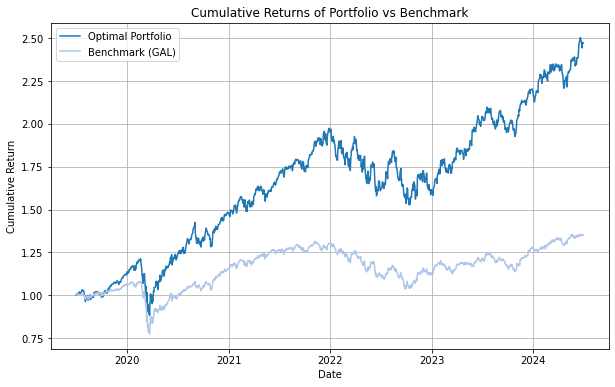

In [131]:
factor_returns = (historical_excess_returns * optimal_weights).sum(axis=1)

# Convert the resulting Series to a DataFrame and preserve the Date index
factor_returns = factor_returns.to_frame(name='Portfolio Returns')

# If you want to keep the original date index and display it:
factor_returns.index.name = 'Date'


# Add the risk-free rate back to get actual returns
portfolio_actual_returns = factor_returns + daily_risk_free_rate.mean()

# Calculate cumulative returns
cumulative_factor_returns = (1 + portfolio_actual_returns).cumprod()
cumulative_benchmark_returns = (1 + daily_market_returns).cumprod()  # Using GAL as the benchmark

# Plot the cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cumulative_factor_returns, label='Optimal Portfolio')
plt.plot(cumulative_benchmark_returns, label='Benchmark (GAL)')
plt.title('Cumulative Returns of Portfolio vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


The plot illustrates the trade-off between maximizing returns and managing risk, highlighting the success of the optimization strategy in outperforming the benchmark while also showcasing the increased volatility associated with this approach.

## 5. Start with three Factor Fama French model

Kenneth French data library hosted at Dartmouth. It retrieves a ZIP file containing the daily factors (market, size, and value premiums) and then extracts and reads the CSV file for analysis. This dataset is essential for conducting the three-factor Fama-French model analysis, which will help in understanding how the assets in the SPDR SSgA Global Allocation ETF are exposed to these specific risk factors. This analysis will support further adjustments in the Black-Litterman model later in your study. We are using the Developed World daily data to refelct our benchmark rather than the US. It is important the note that the Fama French data is centered around equities data and considering we have fixed income instruments in our portfolio we are expecting to see this reflected in the results.

In [132]:
# URL of the ZIP file
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_3_Factors_Daily_CSV.zip"

# Request the content of the URL
response = requests.get(url)

# Open the ZIP file in memory
z = zipfile.ZipFile(io.BytesIO(response.content))

# Extract the CSV file from the ZIP file
csv_filename = z.namelist()[0]  # Get the first file name in the zip file
data = pd.read_csv(z.open(csv_filename), skiprows=5)

In [133]:
# Clean the data 
data = data[pd.to_numeric(data.iloc[:, 0], errors='coerce').notnull()]

# Convert the first column to a datetime format
data['Date'] = pd.to_datetime(data.iloc[:, 0], format='%Y%m%d')

# Drop the original column
data = data.drop(columns=data.columns[0])

# Reorder the columns to place 'Date' at the beginning
data = data[['Date'] + data.columns[:-1].tolist()]

# Divide all the values (except the Date column) by 100
data.iloc[:, 1:] = data.iloc[:, 1:] / 100

# Filter the data for the date range from 01/July/2017 to 28/June/2024
start_date = '2019-07-02'
end_date = '2024-06-28'
ff3 = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Display the first few rows of the filtered data
ff3

,Date,Mkt-RF,SMB,HML,RF
7566,2019-07-02,0.0032,-0.0020,-0.0045,0.0001
7567,2019-07-03,0.0062,-0.0029,-0.0022,0.0001
7568,2019-07-04,0.0012,0.0018,0.0016,0.0001
7569,2019-07-05,-0.0043,0.0005,0.0041,0.0001
7570,2019-07-08,-0.0060,-0.0026,-0.0003,0.0001
...,...,...,...,...,...
8865,2024-06-24,0.0015,0.0027,0.0095,0.0002
8866,2024-06-25,0.0022,-0.0051,-0.0065,0.0002
8867,2024-06-26,-0.0013,-0.0020,-0.0033,0.0002
8868,2024-06-27,0.0004,0.0041,-0.0002,0.0002


In [134]:
# Now, perform the join on the 'Date' index
combined_data = pd.merge(historical_excess_returns, ff3, on='Date')

# Display the first few rows of the combined dataset to verify
combined_data

combined_data = combined_data.drop('RF', axis=1)

c:\Users\kiera\anaconda3\lib\site-packages\pypfopt\plotting.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


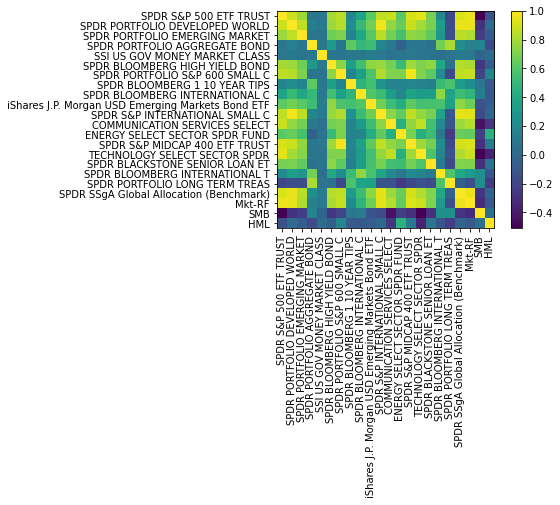

In [135]:
# Correlation matrix
correlation_matrix = combined_data.corr()

plotting.plot_covariance(correlation_matrix, plot_correlation=True);

The correlation matrix heatmap of various ETFs and factors, including the market risk premium (Mkt-RF), size factor (SMB), and value factor (HML). The correlation matrix visually represents the relationships between the assets and these factors, with colors indicating the strength and direction of the correlations. This analysis is crucial for understanding how the underlying assets of the SPDR SSgA Global Allocation ETF relate to different risk factors

In [136]:
#Example regression first
X = combined_data[['Mkt-RF', 'SMB', 'HML']]  # Independent variables (Fama-French factors)
y = combined_data['SPDR S&P 500 ETF TRUST']  # Dependent variable (S&P 500 returns) from the portfolio

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
model_SP500 = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model_SP500.summary())


                              OLS Regression Results                              
Dep. Variable:     SPDR S&P 500 ETF TRUST   R-squared:                       0.965
Model:                                OLS   Adj. R-squared:                  0.964
Method:                     Least Squares   F-statistic:                 1.135e+04
Date:                    Thu, 22 Aug 2024   Prob (F-statistic):               0.00
Time:                            20:36:42   Log-Likelihood:                 5759.2
No. Observations:                    1257   AIC:                        -1.151e+04
Df Residuals:                        1253   BIC:                        -1.149e+04
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -

c:\Users\kiera\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Using the S&P 500 as an example first, the regression analysis using the Fama-French factors on the S&P 500 ETF (SPY) reveals significant insights:

Market Risk Premium (Mkt-RF): The strong positive coefficient (1.0354) indicates that the S&P 500 is highly sensitive to overall market movements, which is expected for a broad market index. Despite using Developed market data rather than US it still has high sensitivity showing the influence of the US.

Size Factor (SMB): The negative coefficient (-0.6164) suggests that the S&P 500 leans towards larger-cap stocks, which typically have lower exposure to the SMB factor. As to be expected with the S&P 500.

Value Factor (HML): The slightly positive coefficient (0.0840) reflects a mild tilt towards value stocks.

Overall, the model explains 96.5% of the variation in S&P 500 returns (R-squared = 0.965), showing that these factors are highly relevant in capturing the index's performance.

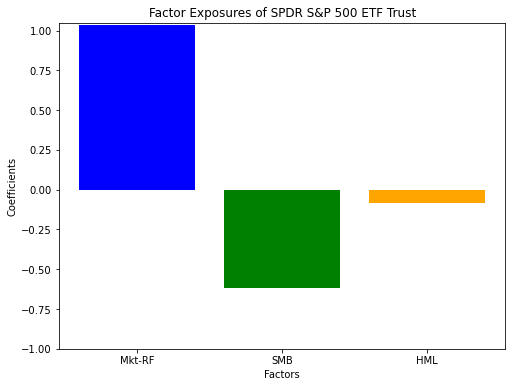

In [137]:
coefficients = model_SP500.params[1:]  
factors = ['Mkt-RF', 'SMB', 'HML']  

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(factors, coefficients, color=['blue', 'green', 'orange'])
plt.xlabel('Factors')
plt.ylabel('Coefficients')
plt.title('Factor Exposures of SPDR S&P 500 ETF Trust')
plt.ylim(-1, 1.05)  # Set limits to make the graph more readable

# Display the plot
plt.show()


In [138]:
combined_data

,Date,SPDR S&P 500 ETF TRUST,SPDR PORTFOLIO DEVELOPED WORLD,SPDR PORTFOLIO EMERGING MARKET,SPDR PORTFOLIO AGGREGATE BOND,SSI US GOV MONEY MARKET CLASS,SPDR BLOOMBERG HIGH YIELD BOND,SPDR PORTFOLIO S&P 600 SMALL C,SPDR BLOOMBERG 1 10 YEAR TIPS,SPDR BLOOMBERG INTERNATIONAL C,...,ENERGY SELECT SECTOR SPDR FUND,SPDR S&P MIDCAP 400 ETF TRUST,TECHNOLOGY SELECT SECTOR SPDR,SPDR BLACKSTONE SENIOR LOAN ET,SPDR BLOOMBERG INTERNATIONAL T,SPDR PORTFOLIO LONG TERM TREAS,SPDR SSgA Global Allocation (Benchmark),Mkt-RF,SMB,HML
0,2019-07-02,0.002520,0.002942,-0.004215,0.001979,-0.000022,0.001853,-0.003988,0.000429,0.002267,...,-0.016079,-0.002674,0.002564,-0.000301,0.001308,0.006749,0.003559,0.0032,-0.0020,-0.0045
1,2019-07-03,0.007911,0.004944,0.002404,0.001973,0.000041,0.003414,0.006774,0.001456,-0.000084,...,0.003900,0.008974,0.007590,-0.000302,0.004782,0.006441,0.005360,0.0062,-0.0029,-0.0022
2,2019-07-05,-0.001223,-0.007090,-0.006979,-0.003851,0.000103,-0.003754,0.003808,-0.003160,-0.001844,...,0.001344,0.000810,-0.001958,0.000133,-0.008041,-0.011755,-0.003437,-0.0043,0.0005,0.0041
3,2019-07-08,-0.005581,-0.006468,-0.005362,-0.000773,-0.000014,-0.001743,-0.010102,-0.000600,-0.005375,...,0.001341,-0.009558,-0.007715,0.000348,-0.001480,0.000964,-0.003449,-0.0060,-0.0026,-0.0003
4,2019-07-09,0.001161,-0.003805,-0.001482,-0.000086,-0.000023,-0.001378,0.000567,-0.000086,0.000209,...,0.000705,0.000111,0.003443,-0.001171,-0.002530,-0.000348,-0.002423,-0.0010,-0.0039,-0.0031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-06-24,-0.003452,0.008349,-0.000440,-0.000202,-0.000025,-0.000519,0.007270,-0.000202,0.003980,...,0.025013,0.005365,-0.024718,0.000517,0.002118,0.003037,0.002088,0.0015,0.0027,0.0095
1253,2024-06-25,0.003649,0.001505,-0.002586,0.000194,-0.000057,0.000750,-0.007715,-0.000202,-0.000896,...,0.002099,-0.009564,0.018142,0.000277,-0.001590,0.001591,-0.000017,0.0022,-0.0051,-0.0065
1254,2024-06-26,0.001046,-0.005883,-0.002327,-0.004953,-0.000058,-0.002844,0.000042,-0.001285,-0.006105,...,-0.010039,-0.003465,-0.001350,-0.000442,-0.006690,-0.013808,-0.002280,-0.0013,-0.0020,-0.0033
1255,2024-06-27,0.001374,0.000941,-0.000468,0.001787,-0.000057,0.001175,0.003948,0.001423,0.002592,...,0.002116,0.003598,0.000284,0.000277,0.001197,0.003791,-0.000433,0.0004,0.0041,-0.0002


Below is the same model using the Benchmark fund instead of the S&P 500.

In [139]:
#Benchmark Test
X = combined_data[['Mkt-RF', 'SMB', 'HML']]  # Independent variables (Fama-French factors)
y = combined_data['SPDR SSgA Global Allocation (Benchmark)']  # Dependent variable (Benchmark)

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
model_benchmark = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model_benchmark.summary())

                                       OLS Regression Results                                      
Dep. Variable:     SPDR SSgA Global Allocation (Benchmark)   R-squared:                       0.922
Model:                                                 OLS   Adj. R-squared:                  0.922
Method:                                      Least Squares   F-statistic:                     4963.
Date:                                     Thu, 22 Aug 2024   Prob (F-statistic):               0.00
Time:                                             20:36:42   Log-Likelihood:                 5831.5
No. Observations:                                     1257   AIC:                        -1.166e+04
Df Residuals:                                         1253   BIC:                        -1.163e+04
Df Model:                                                3                                         
Covariance Type:                                 nonrobust                                         


c:\Users\kiera\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


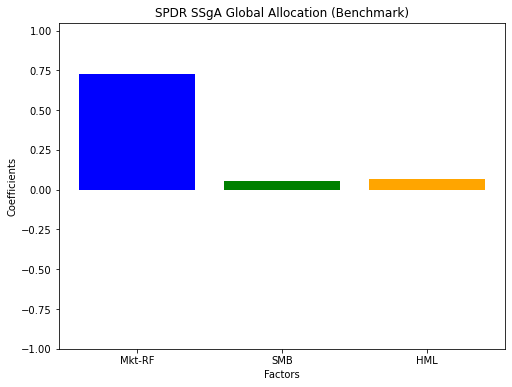

In [140]:
coefficients = model_benchmark.params[1:]  
factors = ['Mkt-RF', 'SMB', 'HML']  

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(factors, coefficients, color=['blue', 'green', 'orange'])
plt.xlabel('Factors')
plt.ylabel('Coefficients')
plt.title('SPDR SSgA Global Allocation (Benchmark)')
plt.ylim(-1, 1.05)  

# Display the plot
plt.show()

The benchmark fund has a more diversified factor exposure, particularly with lower market risk sensitivity given its multi asset exsposure and a slight inclusion of smaller-cap stocks, which contrasts with the S&P 500’s focus on large-cap stocks and higher market exposure. This highlights the benchmark's broader asset allocation strategy compared to the more equity-focused S&P 500.

SPDR SSgA Global Allocation (Benchmark) correlation with market index: 0.9581569116231308
SPDR SSgA Global Allocation (Benchmark) correlation with small-company index: -0.28384528316384827
SPDR SSgA Global Allocation (Benchmark) correlation with value stocks index: -0.026732900742346636


<Figure size 1440x720 with 0 Axes>

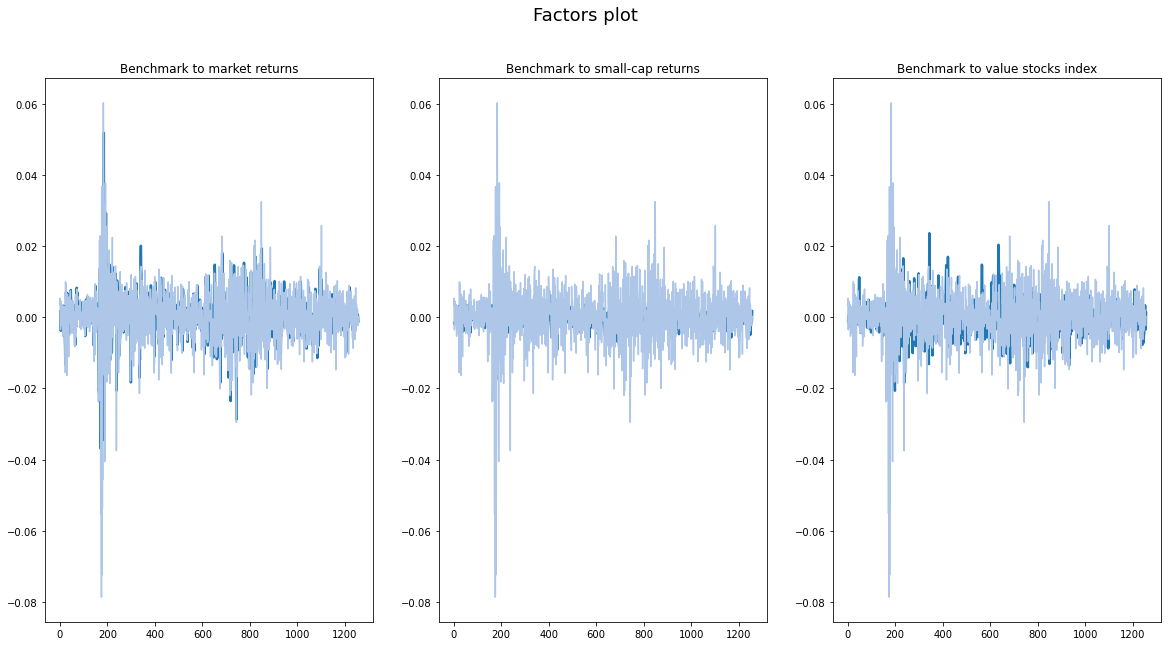

In [141]:
# Set the names for the target variable and factors
stock = 'SPDR SSgA Global Allocation (Benchmark)'  
factors = ['Mkt-RF', 'SMB', 'HML']  # Fama-French factors

# Plot Fama-French factors
plt.figure(figsize=(20, 10))
fig3, axs = plt.subplots(1, 3, figsize=(20, 10))

# Market factor
axs[0].plot(combined_data['Mkt-RF'].rolling(3).mean(), linewidth=2.5)
axs[0].plot(combined_data[stock])
axs[0].set_title(f'Benchmark to market returns')

# Size factor
axs[1].plot(combined_data['SMB'].rolling(3).mean(), linewidth=2.5)
axs[1].plot(combined_data[stock])
axs[1].set_title(f'Benchmark to small-cap returns')

# Value factor
axs[2].plot(combined_data['HML'].rolling(3).mean(), linewidth=2.5)
axs[2].plot(combined_data[stock])
axs[2].set_title(f'Benchmark to value stocks index')

fig3.suptitle('Factors plot', fontsize=18)

# Calculate and print correlations
cor = combined_data.corr()

print(f'{stock} correlation with market index: {cor["Mkt-RF"][stock]}')
print(f'{stock} correlation with small-company index: {cor["SMB"][stock]}')
print(f'{stock} correlation with value stocks index: {cor["HML"][stock]}')


By calculating the Pearson correlation coefficient we detect a strong positive linear relationship between the asset and the overall market trend. This is hardly a suprise, given that it is to be expected that an asset will be influenced by the macroeconomic sutiation. The other 2 factors are more specific and thus their relationship with the asset is much less pronounced.

### 5.2 Applying Factor Models Across Assets

In [142]:
# Set the 'Date' column as the index of combined_data
combined_data.set_index('Date', inplace=True)

# Define the desired factor exposures for each portfolio
portfolios = {
    'Market Portfolio': {'Mkt-RF': 1, 'SMB': 0, 'HML': 0},
    'Small Cap Portfolio': {'Mkt-RF': 0.5, 'SMB': 0.5, 'HML': 0},
    'Value Portfolio': {'Mkt-RF': 0.5, 'SMB': 0, 'HML': 0.5},
    'Balanced Portfolio': {'Mkt-RF': 0.33, 'SMB': 0.33, 'HML': 0.33}
}

# Initialize a DataFrame to store the portfolio returns with the correct date index
factor_returns = pd.DataFrame(index=combined_data.index)

# Calculate the returns for each portfolio
for name, exposures in portfolios.items():
    # Calculate the portfolio returns based on the factor exposures
    factor_returns[name] = sum(combined_data[factor] * weight for factor, weight in exposures.items())


factor_returns.index.name = 'Date'


factor_returns.head()


,Market Portfolio,Small Cap Portfolio,Value Portfolio,Balanced Portfolio
Date,,,,
2019-07-02,0.0032,0.00060,-0.00065,-0.001089
2019-07-03,0.0062,0.00165,0.00200,0.000363
2019-07-05,-0.0043,-0.00190,-0.00010,0.000099
2019-07-08,-0.0060,-0.00430,-0.00315,-0.002937
2019-07-09,-0.0010,-0.00245,-0.00205,-0.002640


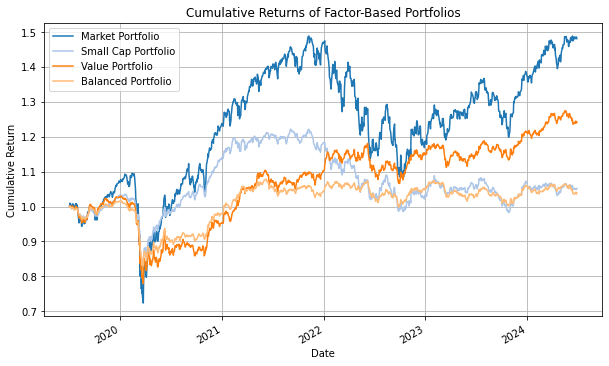

In [143]:
# Calculate cumulative returns for each portfolio
cumulative_returns = (1 + factor_returns).cumprod()

# Plot cumulative returns
cumulative_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns of Factor-Based Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()


The chart shows the cumulative returns of four factor-based portfolios—Market, Small Cap, Value, and Balanced—over time. The Market Portfolio outperforms the others, indicating strong overall market performance. The Small Cap Portfolio is more volatile but lags in cumulative returns, typical of small-cap stocks the last few years. The Value Portfolio shows steady growth but underperforms the market, reflecting the consistent nature of value stocks. The Balanced Portfolio, which combines elements of the others, offers moderate returns, suggesting a more stable investment approach.

In [144]:
# Calculate annualized Sharpe ratio and volatility for each portfolio
annualized_return = factor_returns.mean() * 252  # 252 trading days in a year
annualized_volatility = factor_returns.std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

# Create a DataFrame to display the metrics
performance_metrics = pd.DataFrame({
    'Annualized Return': annualized_return,
    'Annualized Volatility': annualized_volatility,
    'Sharpe Ratio': sharpe_ratio
})

# Display the performance metrics
performance_metrics.sort_values(by='Sharpe Ratio', ascending=False)


,Annualized Return,Annualized Volatility,Sharpe Ratio
Market Portfolio,0.094645,0.177972,0.531798
Value Portfolio,0.048736,0.101912,0.478218
Small Cap Portfolio,0.013653,0.084578,0.161420
Balanced Portfolio,0.009943,0.065281,0.152319


The table shows that the Market Portfolio has the highest annualized return and volatility, leading to the best Sharpe Ratio. The Value Portfolio offers a good balance with a decent Sharpe Ratio. The Small Cap Portfolio and Balanced Portfolio have lower returns and Sharpe Ratios, with the Balanced Portfolio having the lowest volatility, emphasizing stability over high return

In [145]:
# Calculate the Sharpe Ratio components of the Benchmark
benchmark_annualized_return = daily_excess_market_returns.mean() * 252  # Annualizing the mean return
benchmark_annualized_volatility = daily_excess_market_returns.std() * np.sqrt(252)  # Annualizing volatility

# Calculate the Sharpe Ratio 
benchmark_sharpe_ratio = benchmark_annualized_return / benchmark_annualized_volatility

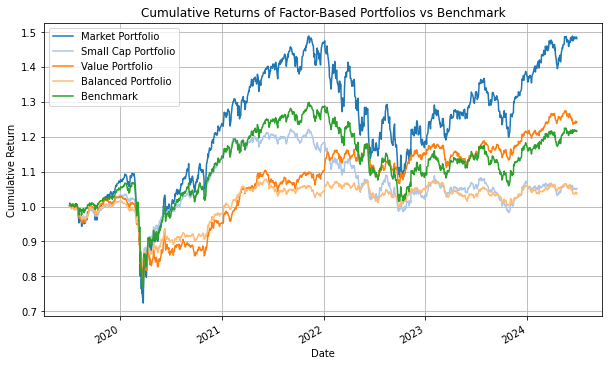

,Annualized Return,Annualized Volatility,Sharpe Ratio
Market Portfolio,0.094645,0.177972,0.531798
Value Portfolio,0.048736,0.101912,0.478218
Benchmark,0.048032,0.133297,0.360341
Small Cap Portfolio,0.013653,0.084578,0.161420
Balanced Portfolio,0.009943,0.065281,0.152319


In [146]:
# Include the benchmark in the analysis
benchmark_returns = (1 + daily_excess_market_returns).cumprod()
benchmark_returns.name = 'Benchmark (GAL)'

# Add benchmark to the cumulative returns DataFrame
cumulative_returns['Benchmark'] = benchmark_returns

# Re-plot cumulative returns including the benchmark
cumulative_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns of Factor-Based Portfolios vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Add benchmark metrics to the performance metrics DataFrame
benchmark_performance = {
    'Annualized Return': benchmark_annualized_return,
    'Annualized Volatility': benchmark_annualized_volatility,
    'Sharpe Ratio': benchmark_sharpe_ratio
}

performance_metrics.loc['Benchmark'] = benchmark_performance

# Display the updated performance metrics
performance_metrics.sort_values(by='Sharpe Ratio', ascending=False)


The chart compares the cumulative returns of various factor-based portfolios (Market, Small Cap, Value, Balanced) against the benchmark (SPDR SSgA Global Allocation). The Market Portfolio clearly outperforms both the benchmark and other portfolios, showing the highest cumulative returns.

In the accompanying table, the Market Portfolio has the highest annualized return (9.46%) and the highest Sharpe Ratio (0.53), indicating superior risk-adjusted performance. The benchmark has moderate performance with a Sharpe Ratio of 0.36, outperforming the Small Cap and Balanced Portfolios, which show lower returns and Sharpe Ratios, reflecting their more conservative or volatile strategies. The Bencmark underperformance can be attributed to a higher exposure to small caps and value exposures.

### 5.3 Rolling Betas

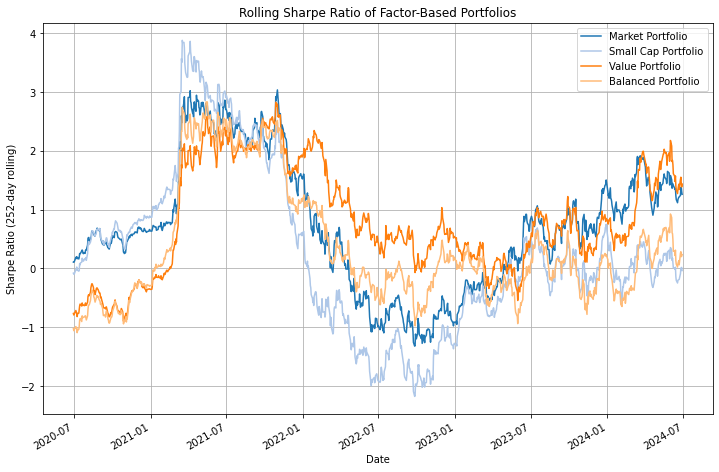

In [147]:
# Calculate rolling Sharpe ratio (using a 252-day window)
rolling_sharpe = factor_returns.rolling(window=252).mean() / factor_returns.rolling(window=252).std() * np.sqrt(252)

# Plot rolling Sharpe ratio
rolling_sharpe.plot(figsize=(12, 8))
plt.title('Rolling Sharpe Ratio of Factor-Based Portfolios')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio (252-day rolling)')
plt.grid(True)
plt.show()

The chart depicts the rolling 252-day Sharpe ratios for various factor-based portfolios (Market, Small Cap, Value, Balanced). The rolling Sharpe ratio allows us to observe how the risk-adjusted returns of these portfolios evolve over time.

- Market Portfolio: Generally shows the highest Sharpe ratio, indicating strong, consistent risk-adjusted performance.
- Small Cap and Value Portfolios: Exhibit more volatility in their Sharpe ratios, reflecting the inherent risks of small-cap and value stocks.
- Balanced Portfolio: Displays moderate Sharpe ratios, indicating more stable but lower risk-adjusted returns.

This chart helps in assessing how the risk-adjusted performance of these portfolios changes over different market conditions.

In [148]:
factor_returns

,Market Portfolio,Small Cap Portfolio,Value Portfolio,Balanced Portfolio
Date,,,,
2019-07-02,0.0032,0.00060,-0.00065,-0.001089
2019-07-03,0.0062,0.00165,0.00200,0.000363
2019-07-05,-0.0043,-0.00190,-0.00010,0.000099
2019-07-08,-0.0060,-0.00430,-0.00315,-0.002937
2019-07-09,-0.0010,-0.00245,-0.00205,-0.002640
...,...,...,...,...
2024-06-24,0.0015,0.00210,0.00550,0.004521
2024-06-25,0.0022,-0.00145,-0.00215,-0.003102
2024-06-26,-0.0013,-0.00165,-0.00230,-0.002178


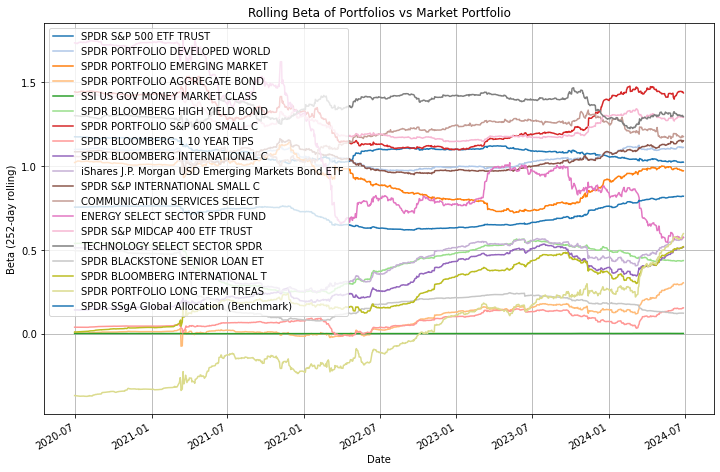

In [149]:
# Define the rolling beta calculation
def calculate_rolling_beta(factor_returns, benchmark_returns, window=252):
    # Calculate rolling covariance of portfolio returns with benchmark returns
    rolling_covariance = factor_returns.rolling(window).cov(benchmark_returns)
    
    # Calculate rolling variance of the benchmark returns
    rolling_variance = benchmark_returns.rolling(window).var()
    
    # Calculate rolling beta
    rolling_beta = rolling_covariance / rolling_variance
    
    return rolling_beta

# Initialize a DataFrame to store rolling betas
rolling_betas = pd.DataFrame(index=factor_returns.index)

# Calculate rolling beta for each portfolio
for portfolio in historical_excess_returns.columns:
    rolling_betas[portfolio] = calculate_rolling_beta(historical_excess_returns[portfolio], factor_returns['Market Portfolio'])

# Plot the rolling beta
rolling_betas.plot(figsize=(12, 8))
plt.title('Rolling Beta of Portfolios vs Market Portfolio')
plt.xlabel('Date')
plt.ylabel('Beta (252-day rolling)')
plt.grid(True)
plt.show()


The chart shows the rolling 252-day beta of various factor-based portfolios relative to the Market Portfolio. Beta measures the sensitivity of each portfolio's returns to the index.

SPDR S&P 500 ETF Trust has a stable beta close to 1, indicating it moves in line with the Markett. No surpises there
SPDR Portfolio Developed World and SPDR Portfolio Emerging Market show betas greater than 1, indicating higher volatility relative to the S&P 500.
Bond ETFs like SPDR Bloomberg International C and SPDR Portfolio Aggregate Bond show low or even negative betas, indicating they are less correlated or inversely correlated with the S&P 500.
This analysis highlights the different risk profiles of the portfolios relative to the market.

In [150]:
# Initialize a DataFrame to store the results
factor_exposures = pd.DataFrame(columns=['Mkt-RF', 'SMB', 'HML'])

# Loop through each asset class in the historical_excess_returns
for asset in historical_excess_returns.columns:
    # Set up the regression model
    X = combined_data[['Mkt-RF', 'SMB', 'HML']]
    y = combined_data[asset]
    
    # Add a constant (intercept) to the model
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Store the factor loadings (coefficients)
    factor_exposures.loc[asset] = model.params[['Mkt-RF', 'SMB', 'HML']]

c:\Users\kiera\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [151]:
# Sort the factor exposures by the HML column in ascending order
sorted_exposures = factor_exposures.sort_values(by='HML', ascending=True)


sorted_exposures

,Mkt-RF,SMB,HML
TECHNOLOGY SELECT SECTOR SPDR,1.184618,-0.903708,-0.668888
COMMUNICATION SERVICES SELECT,1.027396,-0.602052,-0.402317
SPDR PORTFOLIO LONG TERM TREAS,-0.085321,0.501422,-0.363793
SPDR PORTFOLIO AGGREGATE BOND,0.083652,0.230900,-0.090715
SPDR S&P 500 ETF TRUST,1.035400,-0.616411,-0.083961
SPDR BLOOMBERG INTERNATIONAL T,0.234772,0.505596,-0.075790
SPDR BLOOMBERG INTERNATIONAL C,0.317219,0.410292,-0.052132
SPDR BLOOMBERG 1 10 YEAR TIPS,0.081267,0.126334,-0.026420
iShares J.P. Morgan USD Emerging Markets Bond ETF,0.500666,0.188255,-0.002699
SSI US GOV MONEY MARKET CLASS,0.000689,0.000166,0.000327


The table presented shows the factor exposures (loadings) of various asset classes to the Fama-French three factors: Market (Mkt-RF), Size (SMB), and Value (HML).

- Market Exposure (Mkt-RF): Most assets have positive exposure, indicating that they move in the same direction as the market, with technology and energy sector ETFs showing particularly high market sensitivity.
- Size Exposure (SMB): A negative SMB value indicates a bias toward large-cap stocks, while a positive value suggests a tilt towards small-cap stocks.
- Value Exposure (HML): Negative values indicate a growth orientation, while positive values suggest a value orientation.

The table shows factor loadings (coefficients) for different assets sorted by their exposure to the HML (High Minus Low) factor, which reflects a tilt towards value or growth stocks:

Technology Select Sector SPDR and Communication Services Select exhibit negative HML loadings, indicating a tilt towards growth stocks (low book-to-market ratio). This will be key for our Black Litterman views later.



In [152]:
# Sort the factor exposures by the HML column in ascending order
sorted_exposures = factor_exposures.sort_values(by='SMB', ascending=True)

sorted_exposures['SMB']

TECHNOLOGY SELECT SECTOR SPDR                       -0.903708
SPDR S&P 500 ETF TRUST                              -0.616411
COMMUNICATION SERVICES SELECT                       -0.602052
ENERGY SELECT SECTOR SPDR FUND                      -0.109222
SPDR BLACKSTONE SENIOR LOAN ET                      -0.097006
SPDR BLOOMBERG HIGH YIELD BOND                      -0.001472
SSI US GOV MONEY MARKET CLASS                        0.000166
SPDR S&P MIDCAP 400 ETF TRUST                        0.014478
SPDR SSgA Global Allocation (Benchmark)              0.054329
SPDR PORTFOLIO DEVELOPED WORLD                       0.055773
SPDR PORTFOLIO EMERGING MARKET                       0.091448
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.126334
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.188255
SPDR PORTFOLIO AGGREGATE BOND                        0.230900
SPDR PORTFOLIO S&P 600 SMALL C                       0.336597
SPDR BLOOMBERG INTERNATIONAL C                       0.410292
SPDR S&P

The table shows the sorted SMB (Small Minus Big) factor exposures for various assets. Negative values indicate a preference for larger companies, while positive values indicate a tilt towards smaller companies:

Technology Select Sector SPDR and SPDR S&P 500 ETF Trust have significant negative SMB loadings, reflecting a strong bias towards larger-cap stocks.

#### 5.4 Momentum Factor

The momentum factor is based on the observation that stocks that have performed well in the past tend to continue performing well in the near future, and vice versa for poorly performing stocks. This concept was first formalized in financial literature by Jegadeesh and Titman in 1993, who found that a strategy of buying past winners and selling past losers could generate significant positive returns over a 3- to 12-month period.

Momentum as a factor captures the tendency of asset prices to exhibit trends, which can be due to behavioral biases like investor overreaction or underreaction to information, or market inefficiencies. By calculating the 12-month momentum, we are identifying assets with strong recent performance trends, which can then be incorporated into models alongside other factors like market, size, and value.

In [153]:
# Calculate 12-month (252 trading days) momentum
momentum = historical_excess_returns.rolling(window=252).sum()

# Drop any NaN values that result from the rolling calculation
momentum = momentum.dropna()

# Display the momentum values for the last few dates to identify recent trends
momentum


,SPDR S&P 500 ETF TRUST,SPDR PORTFOLIO DEVELOPED WORLD,SPDR PORTFOLIO EMERGING MARKET,SPDR PORTFOLIO AGGREGATE BOND,SSI US GOV MONEY MARKET CLASS,SPDR BLOOMBERG HIGH YIELD BOND,SPDR PORTFOLIO S&P 600 SMALL C,SPDR BLOOMBERG 1 10 YEAR TIPS,SPDR BLOOMBERG INTERNATIONAL C,iShares J.P. Morgan USD Emerging Markets Bond ETF,SPDR S&P INTERNATIONAL SMALL C,COMMUNICATION SERVICES SELECT,ENERGY SELECT SECTOR SPDR FUND,SPDR S&P MIDCAP 400 ETF TRUST,TECHNOLOGY SELECT SECTOR SPDR,SPDR BLACKSTONE SENIOR LOAN ET,SPDR BLOOMBERG INTERNATIONAL T,SPDR PORTFOLIO LONG TERM TREAS,SPDR SSgA Global Allocation (Benchmark)
Date,,,,,,,,,,,,,,,,,,,
2020-06-30,0.103495,-0.015105,-0.019404,0.077514,0.003225,-0.015853,-0.050827,0.048233,-0.012292,0.009232,-0.027995,0.133365,-0.300000,-0.005253,0.352088,-0.011859,0.010931,0.239296,-0.002360
2020-07-01,0.107975,-0.014069,-0.003837,0.075920,0.003242,-0.014850,-0.061899,0.047306,-0.008405,0.009844,-0.030666,0.148970,-0.308232,-0.009087,0.351146,-0.007164,0.007472,0.231326,-0.001583
2020-07-02,0.105565,-0.009643,0.016212,0.074591,0.003213,-0.010641,-0.062564,0.048797,-0.010395,0.012508,-0.032326,0.140607,-0.301035,-0.013290,0.349379,-0.005254,0.003032,0.225307,-0.001276
2020-07-06,0.122221,0.013876,0.063649,0.078436,0.003113,0.000186,-0.056882,0.052934,-0.000258,0.023964,-0.008224,0.159406,-0.299438,-0.003546,0.368810,-0.001709,0.018352,0.232997,0.015049
2020-07-07,0.117482,0.006279,0.054283,0.080825,0.003122,-0.003543,-0.067101,0.053529,0.005994,0.019840,-0.008308,0.165571,-0.332560,-0.012996,0.366064,-0.006190,0.018449,0.245327,0.011068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,0.186915,0.066145,0.078153,-0.016743,0.003440,0.053863,0.069133,-0.010086,-0.008586,0.042346,0.021406,0.252983,0.156501,0.121844,0.237922,0.043747,-0.072023,-0.068713,0.068339
2024-06-25,0.198322,0.083898,0.090010,-0.018716,0.003182,0.057883,0.078261,-0.011714,-0.006117,0.041067,0.040459,0.266337,0.165985,0.124200,0.267113,0.044704,-0.073415,-0.075993,0.074320
2024-06-26,0.203654,0.076019,0.084345,-0.024649,0.003138,0.053368,0.071517,-0.012799,-0.015552,0.034571,0.030722,0.276441,0.138177,0.112431,0.273137,0.044221,-0.083008,-0.090600,0.073254


In [154]:
# Get the momentum values for the most recent date
latest_momentum = momentum.iloc[-1]

# Sort the assets by momentum
sorted_momentum = latest_momentum.sort_values()

# Display assets with highest positive momentum
print("Assets with highest positive momentum:")
print(sorted_momentum.tail(10))

# Display assets with highest negative momentum
print("\nAssets with highest negative momentum:")
print(sorted_momentum.head(10))

Assets with highest positive momentum:
SPDR BLOOMBERG HIGH YIELD BOND             0.043436
SPDR PORTFOLIO S&P 600 SMALL C             0.066469
SPDR SSgA Global Allocation (Benchmark)    0.067627
SPDR PORTFOLIO DEVELOPED WORLD             0.068946
SPDR PORTFOLIO EMERGING MARKET             0.081409
SPDR S&P MIDCAP 400 ETF TRUST              0.103084
ENERGY SELECT SECTOR SPDR FUND             0.131925
SPDR S&P 500 ETF TRUST                     0.189824
COMMUNICATION SERVICES SELECT              0.251631
TECHNOLOGY SELECT SECTOR SPDR              0.252796
Name: 2024-06-28 00:00:00, dtype: float64

Assets with highest negative momentum:
SPDR PORTFOLIO LONG TERM TREAS                      -0.103861
SPDR BLOOMBERG INTERNATIONAL T                      -0.080846
SPDR PORTFOLIO AGGREGATE BOND                       -0.027815
SPDR BLOOMBERG INTERNATIONAL C                      -0.012421
SPDR BLOOMBERG 1 10 YEAR TIPS                       -0.011723
SSI US GOV MONEY MARKET CLASS                    

Assets with Positive Momentum: These assets have shown strong recent performance. The Technology Select Sector SPDR and Communication Services Select are leading with the highest positive momentum, suggesting these sectors have been outperforming the market recently.

Assets with Negative Momentum: Conversely, assets like the SPDR Portfolio Long Term Treasuries and Bloomberg International T have negative momentum, indicating they have underperformed recently.


Using these trends when creating are views later will be key. We have already highlighted our preference for the Growth and Lrge cap exposure and the fact similar assets are demonstrating strong momentum is key. 

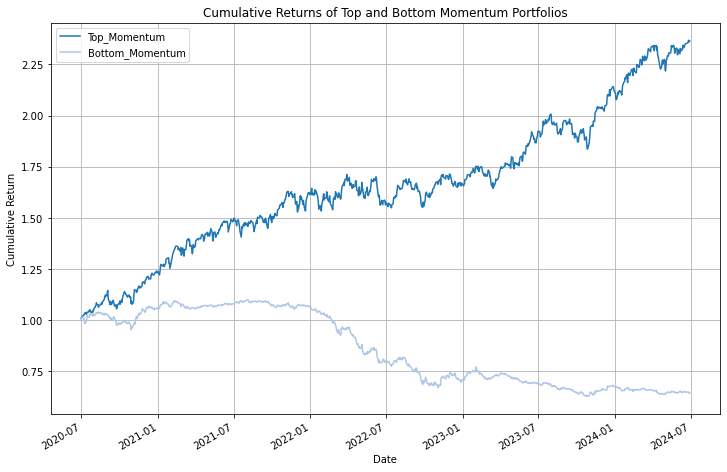

In [155]:
# Number of assets to include in the top and bottom momentum portfolios
num_assets = 5

# Initialize DataFrames to store the returns of the selected portfolios
top_momentum_returns = pd.DataFrame(index=momentum.index)
bottom_momentum_returns = pd.DataFrame(index=momentum.index)

# Loop through each date to select top and bottom momentum assets and calculate portfolio returns
for date in momentum.index:
    # Sort momentum for this date
    sorted_momentum = momentum.loc[date].sort_values()

    # Select top and bottom momentum assets
    top_assets = sorted_momentum.tail(num_assets).index
    bottom_assets = sorted_momentum.head(num_assets).index

    # Calculate average returns for the top and bottom momentum portfolios
    top_momentum_returns.loc[date, 'Top_Momentum'] = historical_excess_returns.loc[date, top_assets].mean()
    bottom_momentum_returns.loc[date, 'Bottom_Momentum'] = historical_excess_returns.loc[date, bottom_assets].mean()

# Combine the returns into a single DataFrame
mom_portfolio_returns = pd.concat([top_momentum_returns, bottom_momentum_returns], axis=1).dropna()

# Calculate cumulative returns
cumulative_returns = (1 + mom_portfolio_returns).cumprod()

# Plot the cumulative returns
cumulative_returns.plot(figsize=(12, 8), title="Cumulative Returns of Top and Bottom Momentum Portfolios")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True)
plt.show()


This chart displays the cumulative returns of two portfolios: the "Top Momentum" portfolio, which consists of assets with the highest momentum, and the "Bottom Momentum" portfolio, which consists of assets with the lowest momentum.

The "Top Momentum" portfolio shows strong positive cumulative returns over time, indicating that assets with high momentum have continued to perform well. In contrast, the "Bottom Momentum" portfolio shows a decline in cumulative returns, indicating that assets with low momentum have underperformed.

The divergence between the two lines reinforces the effectiveness of momentum as a factor in predicting future performance—assets that have performed well in the recent past tend to continue performing well, while those that have performed poorly tend to continue underperforming.

We have conducted an in-depth factor analysis on the "SPDR SSgA Global Allocation (Benchmark)" and its constituent assets to understand their underlying risk and return drivers. In this analysis, we employed the Fama-French Three-Factor Model and momentum factors to comprehensively evaluate our portfolio's exposures and performance characteristics. The Fama-French model allowed us to decompose the portfolio's returns into three key risk factors: Market Risk Premium (Mkt-RF), Size (SMB), and Value (HML). By running regressions of our portfolio returns against these factors, we identified significant exposures to large-cap and growth-oriented stocks, as evidenced by negative SMB coefficients and positive Mkt-RF coefficients. These indicate a tilt towards larger, more established companies with growth characteristics.

Furthermore, we incorporated the momentum factor to analyze the performance of stocks based on their recent price trends. Our findings revealed that stocks with positive momentum significantly outperformed those with negative momentum, reinforcing the effectiveness of momentum as a predictive factor.

These insights into growth, large-cap, and value exposures will be crucial as we formulate our views for the Black-Litterman model. By incorporating these factor exposures, we can refine our market views and adjust our portfolio to align with our strategic outlook, enhancing our portfolio's risk-return profile in line with our investment objectives.

## 6. Black-Litterman Model

### Background and Theory

The Black-Litterman asset allocation model, as outlined by Black and Litterman (1992), offers a systematic approach to integrating an investor's subjective perspectives on the future performance of a risky asset with those indicated by market equilibrium. Despite originating as an internal working paper at Goldman Sachs rather than from academic research, the model has gained widespread recognition among both practitioners and scholars.

This model can be understood as a Bayesian shrinkage method, which adjusts the expected returns based on an investor's views towards those suggested by the market equilibrium. The procedure generates a set of expected returns by using the market equilibrium as a prior. These are then combined with the returns derived from the investor's subjective views, resulting in a set of posterior expected returns $\mu^{BL}$ and covariances $\Sigma^{BL}$ for the assets.

### Expected Returns

Besides the  advantage of incorporating subjective investor views, the Black-Litterman method has another significant benefit that makes it particularly appealing for portfolio optimization. It is well understood that the Markowitz optimization method is highly sensitive to estimation errors in expected returns and covariances, which can lead to unstable portfolios with extreme weights that diverge sharply from the market equilibrium portfolio, even with minor changes in the inputs. However, the posterior parameters $\mu^{BL}$ and $\Sigma^{BL}$, calculated through the Black-Litterman approach, are partially derived from the market portfolio. This makes them much more practical and reliable inputs for portfolio optimization.

Specifically, when $\mu^{BL}$ and $\Sigma^{BL}$ are used as inputs in a Markowitz optimizer, they result in optimized portfolios that only slightly deviate from the market portfolio, depending on the level of confidence the investor has in their views. This means the resulting portfolios are more stable compared to those generated using the traditional Markowitz optimization with sample estimates. In the extreme scenario, with correctly adjusted parameters, the Markowitz portfolio derived from the Black-Litterman parameters, in the absence of any subjective investor views, will exactly match the market equilibrium portfolio.

The below section will highlight the different examples of expected returns and why they may be unideal for portfolio optimsation.

### Historical Excess Returns 

We used historcal excess returns when conducting time series factor analysis earlier in the paper. 

Historical returns may not be suitable for mean-variance optimization (MVO) due to several key drawbacks, particularly sample risk, which arises from the reliance on past data that may not accurately predict future performance. MVO is highly sensitive to input estimates, and using historical returns can lead to overfitting, where the portfolio is optimized for past scenarios that may not repeat. Additionally, changing market conditions, such as regime shifts, can render historical data irrelevant, while ignoring forward-looking information and reinforcing behavioral biases like recency bias further compromises the reliability of historical returns. These factors can result in unstable, suboptimal portfolios that do not adequately balance risk and return in a forward-looking context.

In [156]:
historical_annualized_excess_returns # calculated earlier in paper

SPDR S&P 500 ETF TRUST                               0.123976
SPDR PORTFOLIO DEVELOPED WORLD                       0.041060
SPDR PORTFOLIO EMERGING MARKET                       0.015137
SPDR PORTFOLIO AGGREGATE BOND                       -0.023779
SSI US GOV MONEY MARKET CLASS                        0.000929
SPDR BLOOMBERG HIGH YIELD BOND                       0.005804
SPDR PORTFOLIO S&P 600 SMALL C                       0.056933
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.004470
SPDR BLOOMBERG INTERNATIONAL C                      -0.044160
iShares J.P. Morgan USD Emerging Markets Bond ETF   -0.026656
SPDR S&P INTERNATIONAL SMALL C                       0.016929
COMMUNICATION SERVICES SELECT                        0.102030
ENERGY SELECT SECTOR SPDR FUND                       0.106217
SPDR S&P MIDCAP 400 ETF TRUST                        0.076034
TECHNOLOGY SELECT SECTOR SPDR                        0.219769
SPDR BLACKSTONE SENIOR LOAN ET                       0.018932
SPDR BLO

### CAPM Excess Returns

The Capital Asset Pricing Model (CAPM) is often used to calculate expected returns for mean-variance optimization by estimating the return of an asset based on its sensitivity to market risk (beta), the risk-free rate, and the expected market return. CAPM's primary advantage is its simplicity and theoretical foundation, linking an asset's return to market risk, which is intuitively appealing for constructing diversified portfolios. However, CAPM has notable limitations: it assumes a single factor (market risk) drives returns, which may oversimplify the complexities of real-world markets. Moreover, the model relies on historical data to estimate beta and market returns, introducing potential inaccuracies similar to those in historical return-based methods. CAPM also assumes all investors have the same expectations and access to information, which is unrealistic, and it may not fully account for other risks or factors influencing asset prices, leading to potential mispricing of assets and suboptimal portfolios.


In [157]:
rf_rate = 0.036  

Using 1-month SOFR 3-year swap rate as the risk free rate the goal is to create a portfolio with stable, durable weights over the medium term. Unlike short-term Treasury bills, which reflect the current interest rate environment, the SOFR 3-year swap rate incorporates market expectations of interest rates over the next three years. This forward-looking nature makes it more suitable for longer-term portfolio strategies, as it helps align your optimization with expected future conditions rather than just current rates.

In [158]:
daily_market_returns = prices['SPDR SSgA Global Allocation (Benchmark)'].pct_change().dropna()
market_prices = prices['SPDR SSgA Global Allocation (Benchmark)']
daily_excess_market_returns = daily_market_returns.sub(daily_risk_free_rate, axis=0).dropna()
daily_market_returns

Date
2019-07-02    0.003643
2019-07-03    0.005444
2019-07-05   -0.003352
2019-07-08   -0.003364
2019-07-09   -0.002337
                ...   
2024-06-24    0.002289
2024-06-25    0.000185
2024-06-26   -0.002078
2024-06-27   -0.000231
2024-06-28    0.000463
Name: SPDR SSgA Global Allocation (Benchmark), Length: 1257, dtype: float64

In [159]:
annualized_market_returns = (1 + daily_market_returns).prod() ** (252 / len(daily_market_returns)) - 1
annualized_market_returns

0.06218272964735472

In [160]:
market_variance = daily_market_returns.var()  # Use ddof=0 for population variance

# Annualize the daily variance
annualized_market_variance = market_variance * 252
annualized_market_variance

0.017768768188948413

In [161]:
# Initialize an empty dictionary to store beta values
betas = {}

# Calculate beta for each asset
for column in returns.columns:
    if column != 'Excess_market_returns':
        # Calculate covariance between asset's excess returns and market's excess returns
        covariance = returns[column].cov(daily_market_returns)
        # Calculate beta
        beta = covariance / market_variance
        betas[column] = beta

In [162]:
# Convert betas to a pandas Series
betas = pd.Series(betas)
betas

SPDR S&P 500 ETF TRUST                               1.431911
SPDR PORTFOLIO DEVELOPED WORLD                       1.412238
SPDR PORTFOLIO EMERGING MARKET                       1.299758
SPDR PORTFOLIO AGGREGATE BOND                        0.128106
SSI US GOV MONEY MARKET CLASS                        0.001084
SPDR BLOOMBERG HIGH YIELD BOND                       0.656873
SPDR PORTFOLIO S&P 600 SMALL C                       1.737926
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.124907
SPDR BLOOMBERG INTERNATIONAL C                       0.393806
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.703055
SPDR S&P INTERNATIONAL SMALL C                       1.415996
COMMUNICATION SERVICES SELECT                        1.421005
ENERGY SELECT SECTOR SPDR FUND                       1.787925
SPDR S&P MIDCAP 400 ETF TRUST                        1.712207
TECHNOLOGY SELECT SECTOR SPDR                        1.682170
SPDR BLACKSTONE SENIOR LOAN ET                       0.438283
SPDR BLO

These betas represent the sensitivity of each ETF's returns relative to the market's returns. A beta greater than 1 indicates that the ETF is expected to move more than the market, while a beta less than 1 indicates lower sensitivity. Notice the Benchmark has a beta of 1 as to be expected.

In [163]:
# Calculate CAPM Expected Returns
CAPM_Return = rf_rate + betas * (annualized_market_returns - rf_rate)

excess_CAPM_Return = CAPM_Return-rf_rate
excess_CAPM_Return

SPDR S&P 500 ETF TRUST                               0.037491
SPDR PORTFOLIO DEVELOPED WORLD                       0.036976
SPDR PORTFOLIO EMERGING MARKET                       0.034031
SPDR PORTFOLIO AGGREGATE BOND                        0.003354
SSI US GOV MONEY MARKET CLASS                        0.000028
SPDR BLOOMBERG HIGH YIELD BOND                       0.017199
SPDR PORTFOLIO S&P 600 SMALL C                       0.045504
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.003270
SPDR BLOOMBERG INTERNATIONAL C                       0.010311
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.018408
SPDR S&P INTERNATIONAL SMALL C                       0.037075
COMMUNICATION SERVICES SELECT                        0.037206
ENERGY SELECT SECTOR SPDR FUND                       0.046813
SPDR S&P MIDCAP 400 ETF TRUST                        0.044830
TECHNOLOGY SELECT SECTOR SPDR                        0.044044
SPDR BLACKSTONE SENIOR LOAN ET                       0.011475
SPDR BLO

### Implied Returns

The first step of the Black-Litterman procedure is a reverse-optimization step that infers the implied returns vector $\pi$ that are implied by the equilibrium weights $w$ using the formula:

$$
\pi = \delta \Sigma w_{mkt}
$$


where

- $\pi$ is the Implied Excess Equilibrium Return Vector ($N \times 1$ column vector);
- $\delta$ is the risk aversion coefficient;
- $\Sigma$ is the covariance matrix of excess returns ($N \times N$ matrix); and,
- $w_{mkt}$ is the market capitalization weight ($N \times 1$ column vector) of the assets.

In theory, Equilibrium returns $\pi$ for the Black-Litterman prior reflect the allocation by ‘all global
investors’ on average.

The steps involve:

- We take market allocations $\tilde{w}$ from some global benchmark, SPDR SSgA Global Allocation in our study.
- Calculate the equilibrium returns with risk-aversion $\delta$
- $\pi$ is the mean of the reference distribution (the prior):

$$
\mu \sim N(\pi, \tau \Sigma)
$$


### Reverse Optimization

How did we calculate $\tilde{w} \rightarrow \pi$?

$$
\text{argmax}_w \{ w' \pi - \delta w' \Sigma w \}
$$

Solve reverse optimization problem to obtain equilibrium returns $\pi$ from market index allocations $\tilde{w}$

$$
\pi = 2 \delta \Sigma \tilde{w}
$$

Direct optimization gives the solution for allocations $w^*$,

$$
w^* = \frac{1}{2 \delta} \Sigma^{-1} \pi
$$


In [164]:
# Calculate delta
delta_m = (annualized_market_returns - rf_rate) / (annualized_market_variance)

delta_m

1.4735253096294831

A common approach is to set $\delta$ to the Market Price of Risk (i.e., a measure of the risk aversion of the Representative Investor), which is computed as:

$$
\delta = \frac{\mu_M}{\sigma_M^2}
$$

where $\mu_M$ and $\sigma_M^2$ are estimates of the mean and variance of the returns of the market portfolio. Frequently, a broad market index such as the S\&P500 is taken as a proxy for the market in order to compute the market price of risk from $\mu_M$ and $\sigma_M^2$.


The risk-aversion coefficient 𝛿 not only acts as a scaling factor for the reverse optimization estimate of excess returns but also ensures that the weighted reverse optimized excess returns align with the specified market risk premium, maintaining consistency with market equilibrium. A largerδ increases the estimated excess returns, reflecting higher expected returns per unit of risk as demanded by investors.

In [165]:
# Market Delta (already calculated)
delta_m = (annualized_market_returns - rf_rate) / (annualized_market_variance)

# Trustee Delta (Conservative Investor)
k_trustee = 2  # Adjust this factor based on the level of risk aversion
delta_t = k_trustee * delta_m

# Kelly Investor Delta (Growth-Oriented Investor)
delta_k = 1  # Assuming Kelly Investor uses an optimal growth strategy

print("Market Delta:", delta_m)
print("Trustee Delta:", delta_t)
print("Kelly Investor Delta:", delta_k)

Market Delta: 1.4735253096294831
Trustee Delta: 2.9470506192589663
Kelly Investor Delta: 1


In [166]:
# Calculating Weights that represent the benchhmark. Weights are provided in the ETF documentation.
market_caps = {
    "SPDR S&P 500 ETF TRUST": 48473795.25,
    "SPDR PORTFOLIO DEVELOPED WORLD": 31219646.85,
    "SPDR PORTFOLIO EMERGING MARKET": 26275517.66,
    "SPDR PORTFOLIO AGGREGATE BOND": 18591520.26,
    "SSI US GOV MONEY MARKET CLASS": 16239355.84,
    "SPDR BLOOMBERG HIGH YIELD BOND": 13558107.36,
    "SPDR PORTFOLIO S&P 600 SMALL C": 9619982.39,
    "SPDR BLOOMBERG 1 10 YEAR TIPS": 9182921.44,
    "SPDR BLOOMBERG INTERNATIONAL C": 6968147.81,
    "iShares J.P. Morgan USD Emerging Markets Bond ETF": 6874643.46,
    "SPDR S&P INTERNATIONAL SMALL C": 6425605.01,
    "COMMUNICATION SERVICES SELECT": 4456062.96,
    "ENERGY SELECT SECTOR SPDR FUND": 4395447.32,
    "SPDR S&P MIDCAP 400 ETF TRUST": 4326085.12,
    "TECHNOLOGY SELECT SECTOR SPDR": 4073381.13,
    "SPDR BLACKSTONE SENIOR LOAN ET": 3368004.05,
    "SPDR BLOOMBERG INTERNATIONAL T": 2379148.98,
    "SPDR PORTFOLIO LONG TERM TREAS": 1189617.00
}

# Convert the dictionary to a DataFrame for easier handling
market_caps_df = pd.DataFrame(list(market_caps.items()), columns=['Ticker', 'MarketCap'])

# Calculate the total market capitalization
total_market_cap = market_caps_df['MarketCap'].sum()

# Calculate the market cap weights
market_caps_df['Weight'] = market_caps_df['MarketCap'] / total_market_cap

market_caps_df

,Ticker,MarketCap,Weight
0,SPDR S&P 500 ETF TRUST,48473795.25,0.222748
1,SPDR PORTFOLIO DEVELOPED WORLD,31219646.85,0.143461
2,SPDR PORTFOLIO EMERGING MARKET,26275517.66,0.120742
3,SPDR PORTFOLIO AGGREGATE BOND,18591520.26,0.085432
4,SSI US GOV MONEY MARKET CLASS,16239355.84,0.074624
5,SPDR BLOOMBERG HIGH YIELD BOND,13558107.36,0.062303
6,SPDR PORTFOLIO S&P 600 SMALL C,9619982.39,0.044206
7,SPDR BLOOMBERG 1 10 YEAR TIPS,9182921.44,0.042198
8,SPDR BLOOMBERG INTERNATIONAL C,6968147.81,0.032020
9,iShares J.P. Morgan USD Emerging Markets Bond ETF,6874643.46,0.031591


In [167]:
market_weights= market_caps_df.set_index('Ticker')['Weight']
market_weights

Ticker
SPDR S&P 500 ETF TRUST                               0.222748
SPDR PORTFOLIO DEVELOPED WORLD                       0.143461
SPDR PORTFOLIO EMERGING MARKET                       0.120742
SPDR PORTFOLIO AGGREGATE BOND                        0.085432
SSI US GOV MONEY MARKET CLASS                        0.074624
SPDR BLOOMBERG HIGH YIELD BOND                       0.062303
SPDR PORTFOLIO S&P 600 SMALL C                       0.044206
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.042198
SPDR BLOOMBERG INTERNATIONAL C                       0.032020
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.031591
SPDR S&P INTERNATIONAL SMALL C                       0.029527
COMMUNICATION SERVICES SELECT                        0.020477
ENERGY SELECT SECTOR SPDR FUND                       0.020198
SPDR S&P MIDCAP 400 ETF TRUST                        0.019879
TECHNOLOGY SELECT SECTOR SPDR                        0.018718
SPDR BLACKSTONE SENIOR LOAN ET                       0.015477
S

In [168]:
#dropping the benchmark out
returns.drop(columns=['SPDR SSgA Global Allocation (Benchmark)'], inplace=True)

In [169]:
# Calculate the covariance matrix
cov_matrix = returns.cov()*252

c:\Users\kiera\anaconda3\lib\site-packages\pypfopt\plotting.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


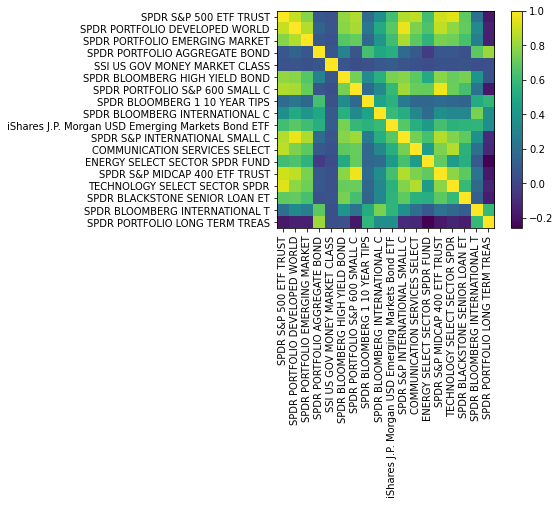

In [170]:
plotting.plot_covariance(cov_matrix, plot_correlation=True);

The heatmap of the covariance (or correlation) matrix is crucial in the context of the Black-Litterman model as it directly influences the model's reverse optimization step and the construction of the implied returns. The off-diagonal elements in the plot show how the assets move in relation to each other, which is essential for calculating the weighted covariance matrix $\Sigma$ used in the Black-Litterman formula $\pi = \delta \Sigma w_{mkt}$.

High correlations (bright cells) suggest that the assets may move together, which can impact the diversification benefits in the portfolio. Low or negative correlations (darker cells) indicate diversification potential. This information allows us to adjust our views and prior assumptions in the Black-Litterman model, ensuring that the optimized portfolio reflects a well-balanced risk-return profile based on actual market relationships.


In [171]:
def implied_returns(delta, sigma, w):
    """
Obtain the implied expected returns by reverse engineering the weights
    """
    ir = delta * sigma.dot(w).squeeze() # to get a series from a 1-column dataframe
    ir.name = 'Implied Returns'
    return ir

In [172]:
# market prior returns
implied_ret = implied_returns(delta_m, cov_matrix, market_weights)
implied_ret

SPDR S&P 500 ETF TRUST                               0.041548
SPDR PORTFOLIO DEVELOPED WORLD                       0.039555
SPDR PORTFOLIO EMERGING MARKET                       0.037207
SPDR PORTFOLIO AGGREGATE BOND                        0.002851
SSI US GOV MONEY MARKET CLASS                        0.000029
SPDR BLOOMBERG HIGH YIELD BOND                       0.018463
SPDR PORTFOLIO S&P 600 SMALL C                       0.049854
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.003015
SPDR BLOOMBERG INTERNATIONAL C                       0.010120
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.019140
SPDR S&P INTERNATIONAL SMALL C                       0.039392
COMMUNICATION SERVICES SELECT                        0.042107
ENERGY SELECT SECTOR SPDR FUND                       0.050694
SPDR S&P MIDCAP 400 ETF TRUST                        0.048839
TECHNOLOGY SELECT SECTOR SPDR                        0.049531
SPDR BLACKSTONE SENIOR LOAN ET                       0.012298
SPDR BLO

In [173]:
#Trustee Delta
implied_ret_t = implied_returns(delta_t, cov_matrix, market_weights)
implied_ret_t

SPDR S&P 500 ETF TRUST                               0.083096
SPDR PORTFOLIO DEVELOPED WORLD                       0.079110
SPDR PORTFOLIO EMERGING MARKET                       0.074414
SPDR PORTFOLIO AGGREGATE BOND                        0.005703
SSI US GOV MONEY MARKET CLASS                        0.000059
SPDR BLOOMBERG HIGH YIELD BOND                       0.036926
SPDR PORTFOLIO S&P 600 SMALL C                       0.099709
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.006030
SPDR BLOOMBERG INTERNATIONAL C                       0.020241
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.038280
SPDR S&P INTERNATIONAL SMALL C                       0.078784
COMMUNICATION SERVICES SELECT                        0.084215
ENERGY SELECT SECTOR SPDR FUND                       0.101388
SPDR S&P MIDCAP 400 ETF TRUST                        0.097679
TECHNOLOGY SELECT SECTOR SPDR                        0.099062
SPDR BLACKSTONE SENIOR LOAN ET                       0.024597
SPDR BLO

In [174]:
#Kelly Delta
implied_ret_k = implied_returns(delta_k, cov_matrix, market_weights)
implied_ret_k

SPDR S&P 500 ETF TRUST                               0.028196
SPDR PORTFOLIO DEVELOPED WORLD                       0.026844
SPDR PORTFOLIO EMERGING MARKET                       0.025250
SPDR PORTFOLIO AGGREGATE BOND                        0.001935
SSI US GOV MONEY MARKET CLASS                        0.000020
SPDR BLOOMBERG HIGH YIELD BOND                       0.012530
SPDR PORTFOLIO S&P 600 SMALL C                       0.033833
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.002046
SPDR BLOOMBERG INTERNATIONAL C                       0.006868
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.012989
SPDR S&P INTERNATIONAL SMALL C                       0.026733
COMMUNICATION SERVICES SELECT                        0.028576
ENERGY SELECT SECTOR SPDR FUND                       0.034403
SPDR S&P MIDCAP 400 ETF TRUST                        0.033145
TECHNOLOGY SELECT SECTOR SPDR                        0.033614
SPDR BLACKSTONE SENIOR LOAN ET                       0.008346
SPDR BLO

The key difference in the prior returns for each delta is that as 𝛿 increases, the implied returns also increase to compensate for higher risk aversion. Conversely, with a lower 𝛿 (like in the Kelly criterion), the implied returns are lower, reflecting a strategy more willing to accept risk for potentially higher long-term growth.

<AxesSubplot:>

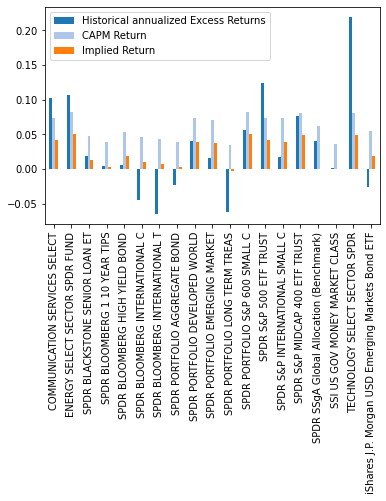

In [175]:
excess_returns_df = pd.DataFrame({
    'Historical annualized Excess Returns': historical_annualized_excess_returns,
    'CAPM Return': CAPM_Return,
    'Implied Return': implied_ret
})

excess_returns_df.plot(kind='bar')

- Historical Annualized Excess Returns are purely backward-looking and do not reflect current or future expectations.
- CAPM Returns are forward-looking but rely on the assumption that market risk is the sole driver of returns.
- Implied Returns are the most nuanced, incorporating both market equilibrium providing a more tailored estimate of expected returns.
The differences in these methods highlight the varying assumptions and perspectives each brings to estimating excess returns, leading to potentially different investment decisions based on which method is used.

## Black Litterman Model

Before continuing, it is important to introduce the Black-Litterman formula and provide a brief description of each of its elements. As noted by Da Silva et al. (2009), we are now focusing on the excess return over the benchmark, π instead of the risk-free return, rf . 

$$
E[R]^{BL} = \left[(\tau \Sigma)^{-1} + P' \Omega^{-1} P\right]^{-1} \left[(\tau \Sigma)^{-1} \Pi + P' \Omega^{-1} Q\right]
$$

$$
\Sigma^{BL} = \Sigma + \left[(\tau \Sigma)^{-1} + P \Omega^{-1} P'\right]^{-1}
$$

where

- $E[R]$ is the new (posterior) Combined Return Vector ($N \times 1$ column vector);
- $\Sigma^{BL}$ is the new (posterior) covariances;
- $\tau$ is a scalar;
- $\Sigma$ is the covariance matrix of excess returns ($N \times N$ matrix);
- $P$ is a matrix that identifies the assets involved in the views ($K \times N$ matrix or $1 \times N$ row vector in the special case of 1 view);
- $\Omega$ is a diagonal covariance matrix of error terms from the expressed views representing the uncertainty in each view ($K \times K$ matrix);
- $\Pi$ is the Implied Equilibrium Return Vector ($N \times 1$ column vector); and,
- $Q$ is the View Vector ($K \times 1$ column vector).


### Views 
A portfolio view can include one or multiple assets by assigning nonzero values to the corresponding elements in the P matrix. An essential concept and a significant application of the Black-Litterman Model is its ability to update views. Essentially, the model allows the integration of views with prior information, leading to the derivation of posterior beliefs. These views reflect the investors' insights and expectations regarding future market movements (Maggiar, 2009). Views can be categorized as Absolute or Relative, and may be either specific to certain assets or encompass broader global perspectives

##### *Absolute vs. Relative Views*
An absolute view refers to specifying the exact level of expected excess return for an asset. For example, you might assert that the expected excess return for asset A is 2%.

In contrast, a relative view compares the expected excess returns between assets, indicating whether one is expected to outperform or underperform another. In this scenario, the sum of all elements in a row equals zero. For instance, you could say that the expected excess return of asset A will exceed that of asset B by 1%.

##### *Asset-Specific vs. Global Views*
An asset-specific view focuses on the expected performance of a single asset. On the other hand, a global view involves expressing expectations about the performance of a group of assets. For example, you might predict that a portfolio consisting of asset A and asset B will outperform a portfolio made up of asset C and asset D.

The matrix 𝑃 is denoted as a 𝐾×𝑁 matrix, where K represents the number of views and 𝑁 represents the number of assets. Each row corresponds to a specific view. q as a K × 1 vector represents the view results
Based on the example provided by Satchell and Scowcroft (2000), we present an example in our context. We will input actual views later.

$$
P = \begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & 1 & 0 & 0 & 0 & 0 \\
\end{pmatrix}
$$

$$

q = \begin{pmatrix}
0.01 \\
0.01 \\
0.02 \\
\end{pmatrix}
$$



####


### Uncertainty of Views

We represent the uncertainty matrix of views with Ω. By assuming that each view is independent, the variance-covariance and correlation between views are set to zero, making Ω a diagonal matrix. Consequently, the off-diagonal elements of Ω are all zero, reflecting the model's assumption of independent views.

While the assumption of independent views might not always be realistic, as investor views can sometimes influence one another, we will not address correlated views in this paper. Modifying correlated views can be done by adjusting the values in the off-diagonal elements of the matrix Ω

There are two types of $\Omega$ matrix used by scholars and practitioners. The first type of matrix is the following. Diagonal elements $\omega_i^2$ imply the uncertainty level of the $i$'s view.

$$
\Omega_{K \times K} = \begin{pmatrix}
\omega_1^2 & 0 & 0 & \cdots & 0 \\
0 & \omega_2^2 & 0 & \cdots & 0 \\
0 & 0 & \ddots & \cdots & 0 \\
0 & 0 & 0 & \cdots & \omega_k^2
\end{pmatrix}
$$

The second type of view is the following equation. In this case, we assume a linear relationship between the variance for all factors ($\Sigma$) and the variance for the views ($\Omega$).

$$
\Omega = P_T \Sigma P^T
$$

The treatment of $\tau$ is the source of some confusion. Some implementors have done away with $\tau$ by setting it to 1 or to calibrate the model to $\textbf{tau}$. In the original model, Black and Litterman suggest using a small number. A common technique is to set $\tau = \frac{1}{T}$ where $T$ is the number of periods of data used. Thus, for $T = 5$ you would use $\frac{1}{(5 \times 12)}$ which yields a value of approximately $\tau = 0.02$. This is the approach we will take.


In [176]:

def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta= 2.5, tau=.02):
    """
# Computes the posterior expected returns based onthe original black litterman reference model
# Omega must be a K x K matrix a DataFrame, or None
# if Omega is None, we assume it is
#    proportional to variance of the prior
# delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    # Force w.prior and Q to be column vectors
    # How many assets do we have?
    N = w_prior.shape[0]
    # And how many views?
    K = q.shape[0]
    # First, reverse-engineer the weights to get pi
    pi = implied_returns(delta, sigma_prior,  w_prior)
    # Adjust (scale) Sigma by the uncertainty scaling factor
    sigma_prior_scaled = tau * sigma_prior # posterior estimate    
    # mu_bl = pi + sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ (q - p @ pi)
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    # posterior estimate of uncertainty of mu.bl
#     sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ p @ sigma_prior_scaled
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)


In [177]:
# To test my model i will apply one view on one of the assets and give it an ER the exact same the prior. 
q = pd.Series({'SPDR S&P 500 ETF TRUST': 0.041548})
q

SPDR S&P 500 ETF TRUST    0.041548
dtype: float64

In [178]:
# Create an empty P matrix with three rows for two views
p = pd.DataFrame([0.] * len(returns.columns), index=returns.columns).T
p = pd.concat([p,], axis=0).reset_index(drop=True)  # Create three rows for three views

# Assign absolute values for the first view (row 0)
p.iloc[0]['SPDR S&P 500 ETF TRUST'] = 1  # Positive view
p

,SPDR S&P 500 ETF TRUST,SPDR PORTFOLIO DEVELOPED WORLD,SPDR PORTFOLIO EMERGING MARKET,SPDR PORTFOLIO AGGREGATE BOND,SSI US GOV MONEY MARKET CLASS,SPDR BLOOMBERG HIGH YIELD BOND,SPDR PORTFOLIO S&P 600 SMALL C,SPDR BLOOMBERG 1 10 YEAR TIPS,SPDR BLOOMBERG INTERNATIONAL C,iShares J.P. Morgan USD Emerging Markets Bond ETF,SPDR S&P INTERNATIONAL SMALL C,COMMUNICATION SERVICES SELECT,ENERGY SELECT SECTOR SPDR FUND,SPDR S&P MIDCAP 400 ETF TRUST,TECHNOLOGY SELECT SECTOR SPDR,SPDR BLACKSTONE SENIOR LOAN ET,SPDR BLOOMBERG INTERNATIONAL T,SPDR PORTFOLIO LONG TERM TREAS
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
# Assumes that Omega is proportional to the variance of the prior, Second option mentioned earlier
def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    # Make a diag matrix from the diag elements of Omega
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)

In [180]:
# Find the Black Litterman Expected Returns
test_bl_mu, test_bl_sigma = bl(market_weights, cov_matrix, p, q,
                omega=None,
                delta=delta_m, tau=0.00001)
# Black Litterman Implied Mu
test_bl_mu

SPDR S&P 500 ETF TRUST                               0.041548
SPDR PORTFOLIO DEVELOPED WORLD                       0.039555
SPDR PORTFOLIO EMERGING MARKET                       0.037207
SPDR PORTFOLIO AGGREGATE BOND                        0.002851
SSI US GOV MONEY MARKET CLASS                        0.000029
SPDR BLOOMBERG HIGH YIELD BOND                       0.018463
SPDR PORTFOLIO S&P 600 SMALL C                       0.049855
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.003015
SPDR BLOOMBERG INTERNATIONAL C                       0.010120
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.019140
SPDR S&P INTERNATIONAL SMALL C                       0.039392
COMMUNICATION SERVICES SELECT                        0.042107
ENERGY SELECT SECTOR SPDR FUND                       0.050694
SPDR S&P MIDCAP 400 ETF TRUST                        0.048839
TECHNOLOGY SELECT SECTOR SPDR                        0.049531
SPDR BLACKSTONE SENIOR LOAN ET                       0.012298
SPDR BLO

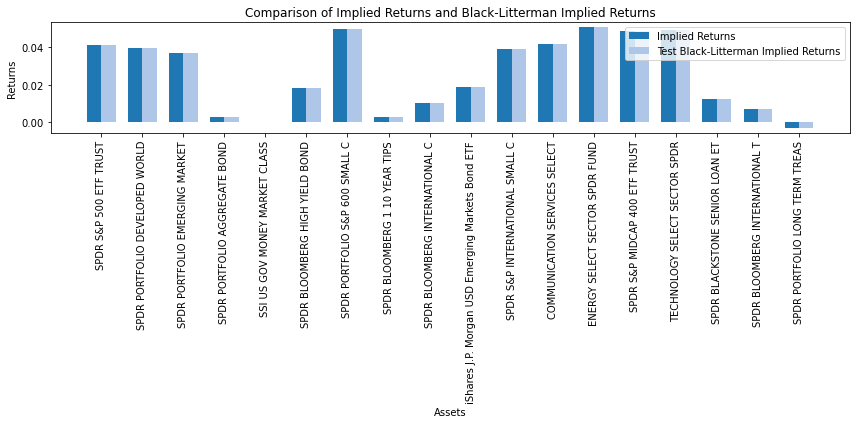

In [181]:
bar_width = 0.35
index = np.arange(len(implied_ret))

plt.figure(figsize=(12, 6))

# Plotting the bar charts
plt.bar(index, implied_ret, bar_width, label='Implied Returns')
plt.bar(index + bar_width, test_bl_mu, bar_width, label='Test Black-Litterman Implied Returns')

# Adding titles and labels
plt.title('Comparison of Implied Returns and Black-Litterman Implied Returns')
plt.xlabel('Assets')
plt.ylabel('Returns')
plt.xticks(index + bar_width / 2, implied_ret.index, rotation=90)
plt.legend()
plt.tight_layout()

plt.show()


Model succesfully outputs implied returns with no views. We will now input our views and see ow the postior changes.

### Our Views

We will rely on our factor analysis that we conducted earlier to place our views on the prior returns. 

1. Absolute View: I expect growth stocks to continue to perform strongly. Growth stocks have outperformed Value for the last ten years driven largely by the huge multi nationals in the US. To benefit from this view of strong growth performance I believe TECHNOLOGY SELECT SECTOR SPDR in our benchmark will have an excess return of 8%, higher than the prior returns of 4.9%.

2. Absolute View: My second absolute view is that bonds will continue to perform poorly. Given the higher inflation environment and rising rates bonds have performed poorly. This is also supported by our momentum factor which highlighted bonds in a negative momentum trend recently which I believe will continue. I expect the SPDR PORTFOLIO LONG TERM TREAS will return -3%, less than the market expectation of basically flat.

3. Relative View: The last view I will implement is a relative one. Based on our factor analysis we saw small cap stocks underperforming large caps. I believe this will continue and want to position myself accordingly. I view that SPDR S&P 500 ETF TRUST a proxy for large caps will outperform SPDR PORTFOLIO S&P 600 SMALL C by 4%.

In [182]:
# Absolute view 1: TECHNOLOGY SELECT SECTOR SPDR will return 8%
# Absolute view 2: SPDR PORTFOLIO LONG TERM TREAS will return -3%
# Absolute view 3: SPDR S&P 500 ETF TRUST will outperform SPDR PORTFOLIO S&P 600 SMALL C by 4%
q = pd.Series({'TECHNOLOGY SELECT SECTOR SPDR': 0.08, 'SPDR PORTFOLIO LONG TERM TREAS': -0.03, 'Large Caps Vs Small Caps': 0.04})
q

TECHNOLOGY SELECT SECTOR SPDR     0.08
SPDR PORTFOLIO LONG TERM TREAS   -0.03
Large Caps Vs Small Caps          0.04
dtype: float64

In [183]:

# Create an empty P matrix with three rows for three views
p = pd.DataFrame([0.] * len(returns.columns), index=returns.columns).T
p = pd.concat([p, p, p], axis=0).reset_index(drop=True)  # Create three rows for three views

# Assign absolute values for the first view (row 0)
p.iloc[0]['TECHNOLOGY SELECT SECTOR SPDR'] = 1  # Positive view
p.iloc[0]['SPDR PORTFOLIO LONG TERM TREAS'] = 0  # No view on this asset in the first view
p.iloc[0]['SPDR S&P 500 ETF TRUST']=0 # No view on this asset in the first view
p.iloc[0]['SPDR PORTFOLIO S&P 600 SMALL C']=0 # No view on this asset in the first view

# Assign absolute values for the second view (row 1)
p.iloc[1]['TECHNOLOGY SELECT SECTOR SPDR'] = 0  # No view on this asset in the second view
p.iloc[1]['SPDR PORTFOLIO LONG TERM TREAS'] = 1  # Negative view
p.iloc[1]['SPDR S&P 500 ETF TRUST']=0 # No view on this asset in the second view
p.iloc[1]['SPDR PORTFOLIO S&P 600 SMALL C']=0 # No view on this asset in the second view

# Assign absolute values for the third view (row 2)
p.iloc[2]['TECHNOLOGY SELECT SECTOR SPDR'] = 0  # No view on this asset in the third view
p.iloc[2]['SPDR PORTFOLIO LONG TERM TREAS'] =  0 # No view on this asset in the third view
p.iloc[2]['SPDR S&P 500 ETF TRUST']=+1
p.iloc[2]['SPDR PORTFOLIO S&P 600 SMALL C']=-1


# Display the P matrix to verify
p


,SPDR S&P 500 ETF TRUST,SPDR PORTFOLIO DEVELOPED WORLD,SPDR PORTFOLIO EMERGING MARKET,SPDR PORTFOLIO AGGREGATE BOND,SSI US GOV MONEY MARKET CLASS,SPDR BLOOMBERG HIGH YIELD BOND,SPDR PORTFOLIO S&P 600 SMALL C,SPDR BLOOMBERG 1 10 YEAR TIPS,SPDR BLOOMBERG INTERNATIONAL C,iShares J.P. Morgan USD Emerging Markets Bond ETF,SPDR S&P INTERNATIONAL SMALL C,COMMUNICATION SERVICES SELECT,ENERGY SELECT SECTOR SPDR FUND,SPDR S&P MIDCAP 400 ETF TRUST,TECHNOLOGY SELECT SECTOR SPDR,SPDR BLACKSTONE SENIOR LOAN ET,SPDR BLOOMBERG INTERNATIONAL T,SPDR PORTFOLIO LONG TERM TREAS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(market_weights, cov_matrix, p, q,
                omega=None,
                delta=delta_m, tau=0.02)
# Black Litterman Implied Mu
bl_mu

SPDR S&P 500 ETF TRUST                               0.048847
SPDR PORTFOLIO DEVELOPED WORLD                       0.040027
SPDR PORTFOLIO EMERGING MARKET                       0.039789
SPDR PORTFOLIO AGGREGATE BOND                       -0.001892
SSI US GOV MONEY MARKET CLASS                        0.000030
SPDR BLOOMBERG HIGH YIELD BOND                       0.017475
SPDR PORTFOLIO S&P 600 SMALL C                       0.033439
SPDR BLOOMBERG 1 10 YEAR TIPS                        0.000424
SPDR BLOOMBERG INTERNATIONAL C                       0.006820
iShares J.P. Morgan USD Emerging Markets Bond ETF    0.014559
SPDR S&P INTERNATIONAL SMALL C                       0.038149
COMMUNICATION SERVICES SELECT                        0.052293
ENERGY SELECT SECTOR SPDR FUND                       0.039397
SPDR S&P MIDCAP 400 ETF TRUST                        0.040552
TECHNOLOGY SELECT SECTOR SPDR                        0.066605
SPDR BLACKSTONE SENIOR LOAN ET                       0.013238
SPDR BLO

In [185]:
post_dif = bl_mu - implied_ret # Difference between the posterior and prior returns after views applied
post_dif = np.round(post_dif,4)

In [186]:
import pandas as pd

# Assuming 'implied_ret', 'bl_mu', and 'post_dif' are Pandas Series with the same index

# Create a DataFrame
bl_dif_df = pd.DataFrame({
    'Prior Returns': implied_ret,
    'Black-Litterman Posterior Returns': bl_mu,
    'Difference': post_dif
})

# Display the DataFrame
bl_dif_df


,Prior Returns,Black-Litterman Posterior Returns,Difference
SPDR S&P 500 ETF TRUST,0.041548,0.048847,0.0073
SPDR PORTFOLIO DEVELOPED WORLD,0.039555,0.040027,0.0005
SPDR PORTFOLIO EMERGING MARKET,0.037207,0.039789,0.0026
SPDR PORTFOLIO AGGREGATE BOND,0.002851,-0.001892,-0.0047
SSI US GOV MONEY MARKET CLASS,0.000029,0.000030,0.0000
SPDR BLOOMBERG HIGH YIELD BOND,0.018463,0.017475,-0.0010
SPDR PORTFOLIO S&P 600 SMALL C,0.049854,0.033439,-0.0164
SPDR BLOOMBERG 1 10 YEAR TIPS,0.003015,0.000424,-0.0026
SPDR BLOOMBERG INTERNATIONAL C,0.010120,0.006820,-0.0033
iShares J.P. Morgan USD Emerging Markets Bond ETF,0.019140,0.014559,-0.0046


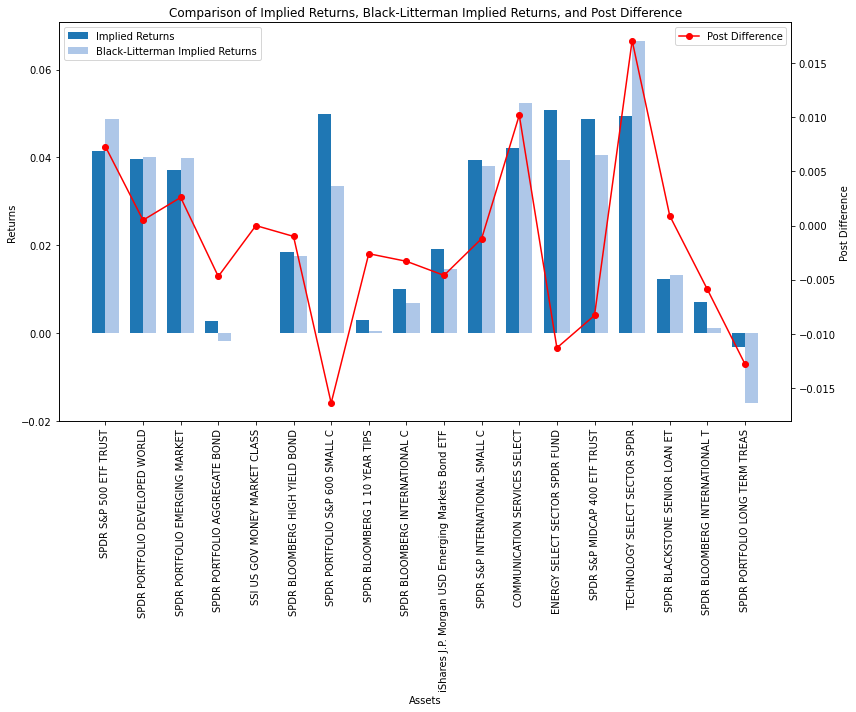

In [187]:
import matplotlib.pyplot as plt
import numpy as np

# Setting the position of bars on the x-axis
bar_width = 0.35
index = np.arange(len(implied_ret))

fig, ax1 = plt.subplots(figsize=(12, 10))

# Plotting the bar charts
bars1 = ax1.bar(index, implied_ret, bar_width, label='Implied Returns')
bars2 = ax1.bar(index + bar_width, bl_mu, bar_width, label='Black-Litterman Implied Returns')

# Adding a secondary axis for post_dif
ax2 = ax1.twinx()
line = ax2.plot(index + bar_width / 2, post_dif, color='red', label='Post Difference', marker='o')

# Adding titles and labels
ax1.set_title('Comparison of Implied Returns, Black-Litterman Implied Returns, and Post Difference')
ax1.set_xlabel('Assets')
ax1.set_ylabel('Returns')
ax2.set_ylabel('Post Difference')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(implied_ret.index, rotation=90)

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Displaying the plot
plt.tight_layout()
plt.show()


The transition from the implied prior returns to the Black-Litterman posterior returns reflects the incorporation of your specified views into the overall market equilibrium. The implied prior returns represent the market-consensus expectations based on the market portfolio weights, while the posterior returns adjust these expectations to reflect our specific views.

- Specifically, the Technology Select Sector SPDR saw a notable increase from an implied return of 4.95% to a posterior return of 6.87%, aligning more closely with our view of strong growth (8% expected return). 
- The SPDR Portfolio Long Term Treasuries, which we anticipate to underperform, had its return adjusted downward from -0.03% to -1.59%, reflecting  negative outlook, though the model moderated the decrease compared to our expectation of -3%. 
- In the case of the SPDR S&P 500 ETF Trust versus the SPDR Portfolio S&P 600 Small Cap, our view that large-cap stocks would outperform small caps led to an increase in the S&P 500’s posterior return to 4.88% and a decrease for the S&P 600 to 3.34%. 

Overall, the model successfully integrates your views, resulting in significant changes where expected, while ensuring that the broader portfolio adjustments maintain equilibrium.

In this section, we applied the Black-Litterman model to incorporate subjective views into our portfolio analysis. We began by calculating the implied returns from market equilibrium and then expressed our specific views. Our views were driven by the factor analysis we completed earlier by targeting exposures in Growth and large caps and underweighting assets which demonstrated negative momentum. These views were incorporated into the Black-Litterman model, adjusting the implied returns to produce the posterior returns. The comparison between these posterior returns and the initial implied returns showed the impact of our views, allowing us to understand how our insights influenced the expected performance of various assets.

## Optimization

With the posterior returns and the updated covariance matrix (sigma), we will now proceed to optimize the portfolio using various techniques. This will help us determine the best asset allocation to achieve our desired balance between risk and return, considering the updated expectations.

Three optimisation methods are employed to establish the portfolio in our paper:

- (1) the global minimum variance portfolio 
- (2) the maximum Sharpe ratio portfolio 
- (3) and finally the Markowitz mean-variance portfolio

They all employ certain optimisation functions given by different constraints to calculate weights,
and we would introduce them in detail as follows. I will introduce some key functions that we will use in our optimisation first. 

In [188]:
#Portfolio Returns
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

In [189]:
#Portfolio Risk
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol 

### GMV

The global minimum variance portfolio has the objective function of minimizing the portfolio variance. As Equation below shows, the portfolio variance is calculated as $ w^T \Sigma w $.

$$
w_{GMV} = \text{arg} \min_{w} w^T \Sigma w
$$

Below function calculates the Global Minimum Variance Portfolio by optimizing asset weights to minimize portfolio variance. It imposes three constraints: the sum of weights must equal 1, no short selling (weights ≥ 0), and no asset can exceed 25% of the portfolio. The result is a DataFrame with each asset's optimal weight.

In [190]:
# Function to calculate the Global Minimum Variance Portfolio
def calculate_gmvp(cov_matrix, asset_names):
    # Number of assets
    n_assets = cov_matrix.shape[0]
    
    # Define the optimization variables
    weights = cp.Variable(n_assets)
    
    # Define the objective function (minimize portfolio variance)
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)
    
    # Define the constraints
    constraints = [
        cp.sum(weights) == 1,  # Sum of weights must be 1
        weights >= 0,          # No short selling (weights >= 0)
        weights <= 0.25        # No more than 25% in any single asset
    ]
    
    # Formulate and solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # Get the optimal weights, rounded to 3 decimal places
    gmvp_weights = weights.value.round(3)
    
    # Create a DataFrame to pair asset names with their corresponding weights
    weights_df = pd.DataFrame({'Asset': asset_names, 'Weight': gmvp_weights})
    
    return weights_df



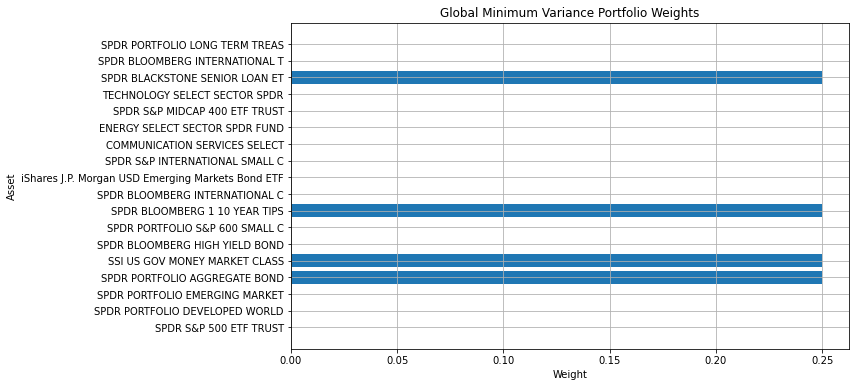

In [191]:
gmv_df = calculate_gmvp(bl_sigma, bl_sigma.columns)

# Plotting the stacked bar chart
plt.figure(figsize=(10, 6))
plt.barh(gmv_df['Asset'], gmv_df['Weight'])

plt.xlabel('Weight')
plt.ylabel('Asset')
plt.title('Global Minimum Variance Portfolio Weights')
plt.grid(True)

# Show plot
plt.show()


The GMV portfolio unsurprisingly allocates towards assets that would be considered relativly less risky. All of the assets it has invested in are fixed income which are less volatile than equirties. I imposed a constriant hat it cannot invest more than 25% in one single asset to avoid 100% allocation to the Money-Market Fund which is considerd cash.

### Max Sharpe Ratio

The Maximum Sharpe Ratio Portfolio is the portfolio that maximizes the Sharpe ratio, which is a measure of risk-adjusted return. The Sharpe ratio is defined as the excess return of the portfolio (the return above the risk-free rate) per unit of risk (measured by the portfolio's standard deviation).

$
w_s = \text{arg}\max_w \frac{w^T (\mu - r_f)}{\sqrt{w^T \Sigma w}} \quad \
$

By solving Equation above, we would obtain the solution as the following:

$$
w_s = \frac{\Sigma^{-1} \mu}{\mu^T \Sigma^{-1} \mu} \quad \
$$

Below function calculates the Maximum Sharpe Ratio (MSR) portfolio by optimizing asset weights to maximize the Sharpe ratio, which measures risk-adjusted returns. It uses SLSQP optimization method, which allows for constraints and bounds, to minimize the negative Sharpe ratio. One constraint: the sum of the asset weights must equal 1. There are no bounds on individual asset weights, allowing full flexibility in asset allocation. The function returns a DataFrame with the optimal weights for each asset.


In [192]:
#Function to calculate MSR
def msr(riskfree_rate, er, cov, asset_names):

    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((None, None),) * n  #No weight limitations initially
    
    # Construct the constraints
    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the Sharpe ratio of the given portfolio.
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate) / vol
    
    weights = minimize(
        neg_sharpe, init_guess,
        args=(riskfree_rate, er, cov),
        method='SLSQP',
        options={'disp': False},
        constraints=(weights_sum_to_1,),
        bounds=bounds
    )
    
    # weights rounded to 3 decimals
    final_weights = np.round(weights.x, 3)
    
    # Create a DataFrame to pair asset names with their corresponding weights
    weights_df = pd.DataFrame({'Asset': asset_names, 'Weight': final_weights})
    
    return weights_df


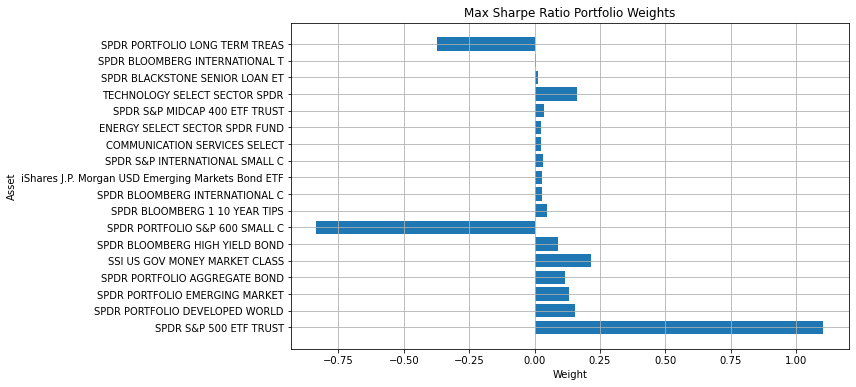

In [193]:
msr_df = msr(0.0, bl_mu, bl_sigma, bl_sigma.columns)#rf rate set to zero as i am working with excess returns

plt.figure(figsize=(10, 6))
plt.barh(msr_df['Asset'], msr_df['Weight'])

plt.xlabel('Weight')
plt.ylabel('Asset')
plt.title('Max Sharpe Ratio Portfolio Weights')
plt.grid(True)

plt.show()

The chart shows the portfolio weights for the Maximum Sharpe Ratio (MSR) portfolio. Without constraints on weights, the optimization has led to extreme allocations, with significant short positions (negative weights) in some assets and large overweights (positive weights) in others. This outcome is typical in unconstrained optimization, where the algorithm aggressively allocates capital to maximize the Sharpe ratio, often resulting in impractical portfolios with high concentration and leverage. Adding constraints, such as limiting short positions or capping individual asset weights, would result in a more balanced and realistic portfolio allocation.

In [194]:
# Calculate the portfolio return using the optimal weights
msr_portfolio_ret = portfolio_return(msr_df['Weight'].values, bl_mu)

# Calculate the portfolio volatility (standard deviation) using the optimal weights
msr_portfolio_volatility = portfolio_vol(msr_df['Weight'].values, bl_sigma)

# Calculate the Sharpe Ratio
msr_nc_sharpe_ratio = np.round(((msr_portfolio_ret) / msr_portfolio_volatility),3)

print("Sharpe Ratio:", msr_nc_sharpe_ratio)

Sharpe Ratio: 0.285


In [195]:
#Function to calculate MSR
def msr(riskfree_rate, er, cov, asset_names):
    """
    Returns the weights of the portfolio that gives you the maximum Sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix.
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0, 1),) * n  #Include no shorting
    
    # Construct the constraints
    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the Sharpe ratio of the given portfolio.
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate) / vol
    
    weights = minimize(
        neg_sharpe, init_guess,
        args=(riskfree_rate, er, cov),
        method='SLSQP',
        options={'disp': False},
        constraints=(weights_sum_to_1,),
        bounds=bounds
    )
    
    # weights rounded to 3 decimals
    final_weights = np.round(weights.x, 3)
    
    # Create a DataFrame to pair asset names with their corresponding weights
    weights_df = pd.DataFrame({'Asset': asset_names, 'Weight': final_weights})
    
    return weights_df


In [196]:
msr_df = msr(0.0, bl_mu, bl_sigma, bl_sigma.columns)
msr_df

,Asset,Weight
0,SPDR S&P 500 ETF TRUST,0.000
1,SPDR PORTFOLIO DEVELOPED WORLD,0.000
2,SPDR PORTFOLIO EMERGING MARKET,0.100
3,SPDR PORTFOLIO AGGREGATE BOND,0.000
4,SSI US GOV MONEY MARKET CLASS,0.089
5,SPDR BLOOMBERG HIGH YIELD BOND,0.000
6,SPDR PORTFOLIO S&P 600 SMALL C,0.000
7,SPDR BLOOMBERG 1 10 YEAR TIPS,0.000
8,SPDR BLOOMBERG INTERNATIONAL C,0.000
9,iShares J.P. Morgan USD Emerging Markets Bond ETF,0.000


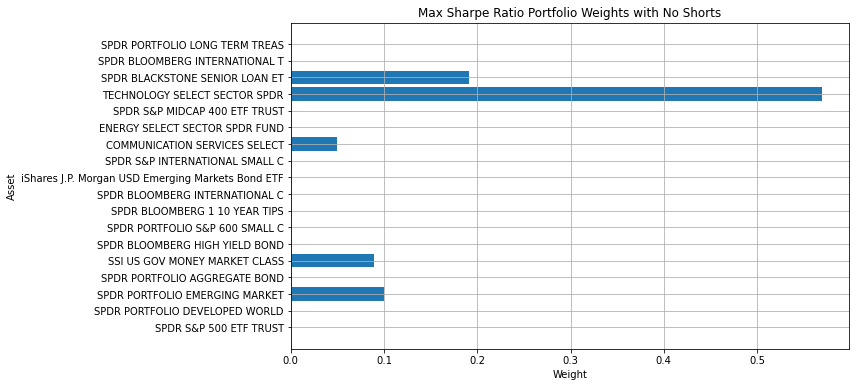

In [197]:

plt.figure(figsize=(10, 6))
plt.barh(msr_df['Asset'], msr_df['Weight'])

plt.xlabel('Weight')
plt.ylabel('Asset')
plt.title('Max Sharpe Ratio Portfolio Weights with No Shorts')
plt.grid(True)

plt.show()

In [198]:
# Calculate the portfolio return using the optimal weights
msr_portfolio_ret = portfolio_return(msr_df['Weight'].values, bl_mu)

# Calculate the portfolio volatility (standard deviation) using the optimal weights
msr_portfolio_volatility = portfolio_vol(msr_df['Weight'].values, bl_sigma)

# Calculate the Sharpe Ratio
msr_nc_sharpe_ratio = np.round(((msr_portfolio_ret) / msr_portfolio_volatility),3)

print("Sharpe Ratio:", msr_nc_sharpe_ratio)

Sharpe Ratio: 0.244


The chart displays the portfolio weights for the Maximum Sharpe Ratio portfolio with a no-shorting constraint applied. While the constraint has eliminated negative weights, the portfolio remains highly concentrated, with a few assets still receiving large allocations. This suggests that, even with no shorting, the optimization heavily favors certain assets to maximize the Sharpe ratio, leading to a lack of diversification. Sharpe Ratio marginally fell to 0.244.

### Markowitz Mean-Variance Portfolio

MVO is a technique used to find the optimal asset allocation (weights 𝑤) in a portfolio that maximizes the expected return for a given level of risk, or alternatively, minimizes the risk for a given level of return.
Obtain the allocations W* by optimization that uses the posterior.

$$
\text{argmax}_{\mathbf{w}} \{ \mathbf{w}' \mu_{BL} - \lambda \mathbf{w}' \Sigma \mathbf{w} \}
$$

The analytical solution, no constraints is

$$
\mathbf{w}^* = \frac{1}{2\lambda} \hat{\Sigma}^{-1} \mu_{BL}
$$

Unconstrained mean-variance has a convenient analytical solution. Constraints improve robustness but require numerical optimization which we will add below.


This function optimizes the asset weights to maximize the portfolio's expected return while keeping the portfolio's risk (volatility) within a specified target. It uses the SLSQP optimization method, which accommodates both constraints and bounds. The initial guess is an equal weighting of assets, and the bounds are set between 0 and 1 for each weight. The function applies two constraints: the sum of the weights must equal 1, and the portfolio's risk must meet the target risk level.

In [199]:
def maximize_return(target_risk, er, cov, asset_names):

    n = er.shape[0]  # Number of assets
    init_guess = np.repeat(1/n, n)  # Initial guess: equal weighting
    bounds = ((0.01, 0.25),) * n  # Bounds for weights: each weight between 1% and 25%

    # Construct the constraints
    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    risk_is_target = {'type': 'ineq', 'args': (cov,), 
                      'fun': lambda weights, cov: target_risk - np.sqrt(np.dot(weights.T, np.dot(cov, weights)))}

    # Maximize the portfolio return
    result = minimize(lambda weights: -np.dot(weights, er),  # We minimize the negative of the expected return to maximize it
                      init_guess,
                      method='SLSQP',
                      options={'disp': False},
                      constraints=(weights_sum_to_1, risk_is_target),
                      bounds=bounds)
    
    # Create a DataFrame with the results and round weights to 3 decimals
    weights_df = pd.DataFrame({
        'Asset': asset_names,
        'Weight': np.round(result.x, 3)
    })
    
    return weights_df


Lets find the optimal weights for the benchmark portfolio given the level of risk that the it currently holds. We will use the market weights and postior returns and posterior sigma and see how the weights change compared to the bencmark/market weights.

In [200]:
benchmark_risk = portfolio_vol(market_weights, bl_sigma)
benchmark_return = portfolio_return(market_weights, bl_mu)
benchmark_sharpe = np.round(((benchmark_return) / benchmark_risk),3)

print("Benchmark Risk:", benchmark_risk, "Benchmark Return:", benchmark_return, "Sharpe Ratio:", benchmark_sharpe)

Benchmark Risk: 0.14176738145834386 Benchmark Return: 0.029707013351385404 Sharpe Ratio: 0.21


In [201]:
benchmark_mvo_weights = maximize_return(0.1417673944181446 , bl_mu, bl_sigma, bl_sigma.columns)# Maximising return for a market weight risk
benchmark_mvo_weights

c:\Users\kiera\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


,Asset,Weight
0,SPDR S&P 500 ETF TRUST,0.112
1,SPDR PORTFOLIO DEVELOPED WORLD,0.010
2,SPDR PORTFOLIO EMERGING MARKET,0.066
3,SPDR PORTFOLIO AGGREGATE BOND,0.010
4,SSI US GOV MONEY MARKET CLASS,0.213
5,SPDR BLOOMBERG HIGH YIELD BOND,0.010
6,SPDR PORTFOLIO S&P 600 SMALL C,0.010
7,SPDR BLOOMBERG 1 10 YEAR TIPS,0.010
8,SPDR BLOOMBERG INTERNATIONAL C,0.010
9,iShares J.P. Morgan USD Emerging Markets Bond ETF,0.010


In [202]:
benchmark_mvo_weights_formatted = benchmark_mvo_weights.set_index('Asset')['Weight'] # Change format of Dataframe for Analysis

In [203]:
mvo_benchmark_risk = portfolio_vol(benchmark_mvo_weights_formatted, bl_sigma)
mvo_benchmark_return = portfolio_return(benchmark_mvo_weights_formatted, bl_mu)

mvo_benchmark_sharpe = np.round(((mvo_benchmark_return) / mvo_benchmark_risk),3)

print("MVO Benchmark Risk:", mvo_benchmark_risk, "MVO Benchmark Return:", mvo_benchmark_return, "MVO Sharpe Ratio:", mvo_benchmark_sharpe)

MVO Benchmark Risk: 0.14164936345480172 MVO Benchmark Return: 0.03364009366457327 MVO Sharpe Ratio: 0.237


Benchmark Portfolio:
Risk: 0.1418
Return: 0.0297
Sharpe Ratio: 0.21
MVO Portfolio:

Risk: 0.1416 
Return: 0.0336 (higher than the benchmark)
Sharpe Ratio: 0.237 (higher than the benchmark)

For the same level of risk, the MVO portfolio achieves a higher return and a better Sharpe Ratio compared to the benchmark portfolio. This suggests that by optimizing the weights of the assets in the portfolio, we can achieve a more efficient allocation that provides better risk-adjusted returns. The improvement in the Sharpe Ratio indicates that the MVO portfolio is more efficient, offering higher returns per unit of risk taken.

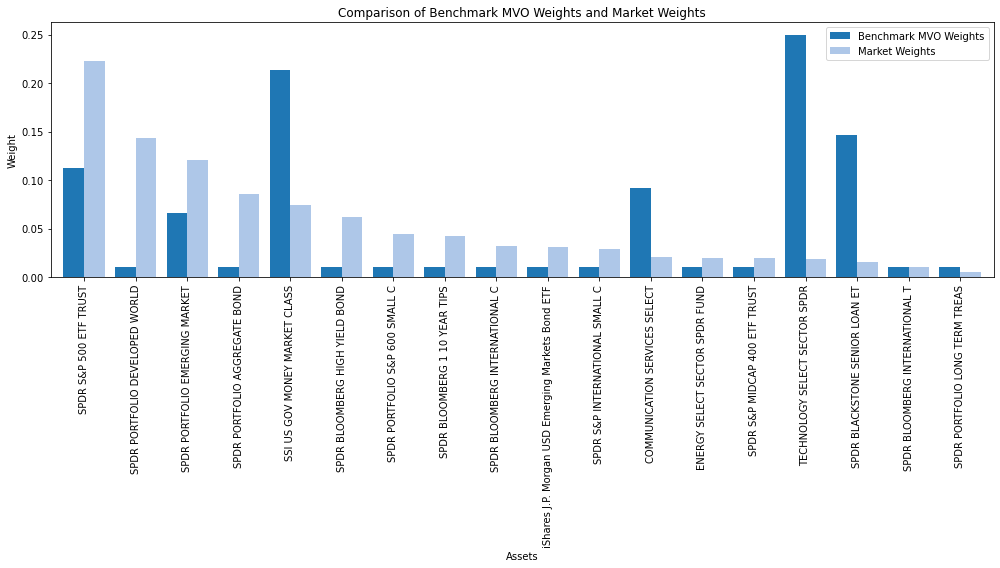

In [204]:
#DataFrame for plotting
mvo_weight_comparison_df = pd.DataFrame({
    'Benchmark MVO Weights': benchmark_mvo_weights_formatted,
    'Market Weights': market_weights
})

# Plotting the bar chart
mvo_weight_comparison_df.plot(kind='bar', figsize=(14, 8), width=0.8)
plt.title('Comparison of Benchmark MVO Weights and Market Weights')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The bar chart shows significant shifts in asset allocation after optimization, with notable increases in Technology Select Sector SPDR and SSI US Gov Money Market Class, reflecting the 25% cap and preference for stability(Constraint of Max 25% in any one asset and a Min of 1%). Conversely, SPDR S&P 500 ETF TRUST and SPDR Portfolio Developed World saw reduced weights. Intersingly, the fixed income allocation increased slightly in the MVO portfolio, with assets like SPDR Blackstone Senior Loan ET gaining more prominence and also the Money Market Fund which is slightly more predicatble. while others were minimized or eliminated due to the constraints against shorting, the 25% max allocation, and the 1% minimum threshold. 

In [205]:
# DataFrame to compare the two sets of information
mvo_comparison_df = pd.DataFrame({
    'Metric': ['Risk', 'Return', 'Sharpe Ratio'],
    'Market Portfolio': [benchmark_risk, benchmark_return, benchmark_sharpe],
    'MVO Portfolio': [mvo_benchmark_risk, mvo_benchmark_return, mvo_benchmark_sharpe]
})

# Display the DataFrame
mvo_comparison_df

,Metric,Market Portfolio,MVO Portfolio
0,Risk,0.141767,0.141649
1,Return,0.029707,0.033640
2,Sharpe Ratio,0.210000,0.237000


The comparison table shows that the MVO Portfolio has essentially the same lebel of risk whih is what we targeted  (0.141649) than the Market Portfolio (0.141767) while achieving a higher return (0.033640 vs. 0.029707). As a result, the Sharpe Ratio for the MVO Portfolio (0.2370) is higher than that of the Market Portfolio (0.210), indicating a more efficient risk-return trade-off after optimization.

#### Varying Weights over a Range of risk tolerances

We eill now make changes in portfolio allocation across different target volatility levels, with a focus on how the weights of various assets adjust as volatility increases. Each colored band represents a specific asset, and the area it occupies on the y-axis shows its corresponding weight in the portfolio. We are going to compare two charts:

- 1. Weights using our poserior returns with views.
- 2. Weights using the market implied returns (Prior).

I have implemented constraints to avoid unrealistic concentration risk and allocated a minimum of 1% to each asset for comparison purposes.

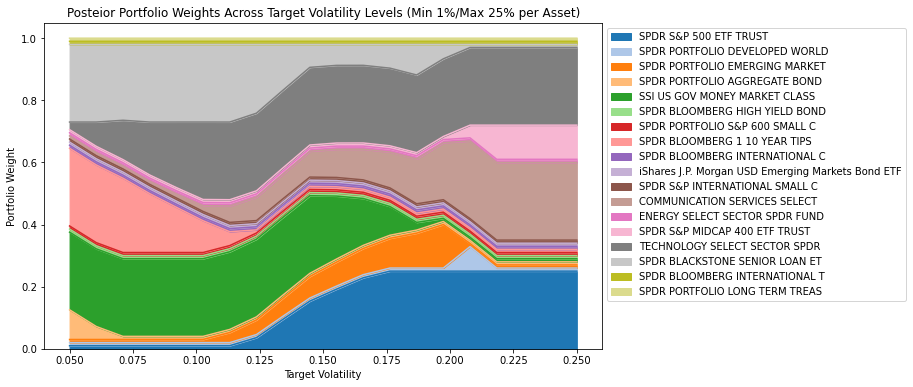

In [206]:
# Define a range of target volatilities (standard deviations)
target_volatilities = np.linspace(0.05, 0.25, 20)  # Adjust the range and number of points as needed

# Store the weights for each target volatility level
weights_dict = {}

# Loop over each target volatility level
for target_volatility in target_volatilities:
    ef = EfficientFrontier(bl_mu, bl_sigma, weight_bounds=(0.01, 0.25))  # 25% max allocation constraint
    ef.efficient_risk(target_volatility=target_volatility, market_neutral=False)
    weights = ef.clean_weights()
    weights_dict[target_volatility] = weights

# Convert the weights dictionary to a DataFrame for easier analysis
weights_df = pd.DataFrame(weights_dict)

# Transpose to make the target volatilities as the index
weights_df = weights_df.T

# Set a Seaborn color palette (you can change "tab20" to any other palette name you prefer)
sns.set_palette("tab20", n_colors=weights_df.shape[1])

# Plotting the area chart with the new color palette
weights_df.plot(kind='area', stacked=True, figsize=(10, 6))
plt.title('Posteior Portfolio Weights Across Target Volatility Levels (Min 1%/Max 25% per Asset)')
plt.xlabel('Target Volatility')
plt.ylabel('Portfolio Weight')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


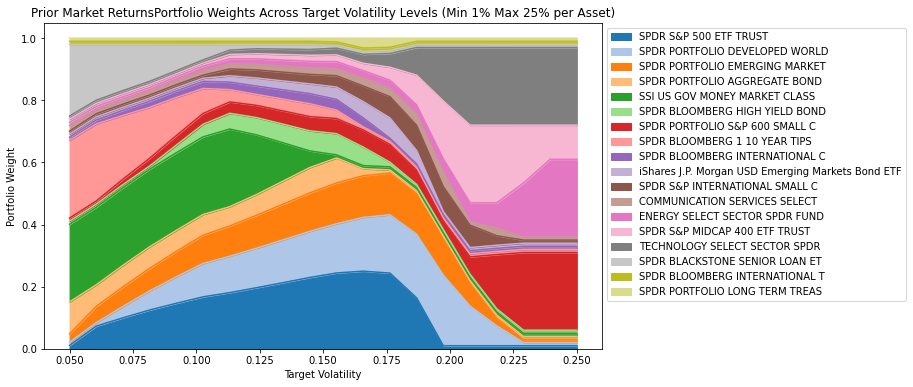

In [207]:
# Define a range of target volatilities (standard deviations)
target_volatilities = np.linspace(0.05, 0.25, 20)  # Adjust the range and number of points as needed

# Store the weights for each target volatility level
weights_dict = {}

# Loop over each target volatility level
for target_volatility in target_volatilities:
    ef = EfficientFrontier(implied_ret, cov_matrix, weight_bounds=(0.01, 0.25))  # 25% max allocation constraint
    ef.efficient_risk(target_volatility=target_volatility, market_neutral=False)
    weights = ef.clean_weights()
    weights_dict[target_volatility] = weights

# Convert the weights dictionary to a DataFrame for easier analysis
weights_df = pd.DataFrame(weights_dict)

# Transpose to make the target volatilities as the index
weights_df = weights_df.T

# Set a Seaborn color palette (you can change "tab20" to any other palette name you prefer)
sns.set_palette("tab20", n_colors=weights_df.shape[1])

# Plotting the area chart with the new color palette
weights_df.plot(kind='area', stacked=True, figsize=(10, 6))
plt.title('Prior Market ReturnsPortfolio Weights Across Target Volatility Levels (Min 1% Max 25% per Asset)')
plt.xlabel('Target Volatility')
plt.ylabel('Portfolio Weight')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

The two charts compare portfolio weights across volatility levels using different return assumptions. The first chart, based on posterior Black-Litterman returns with views, shows more concentrated allocations, particularly in SPDR S&P 500 ETF TRUST and SPDR BLACKSTONE SENIOR LOAN ET and SPDR TECHNOLOGY fund, with significant shifts as volatility increases, indicating a strong conviction in certain assets. This is encouraging to see as our views are being reflected in the allocations.

 In contrast, the second chart, using implied market equilibrium returns, displays a more balanced and diversified allocation with less drastic changes across volatility levels, reflecting a market-neutral approach. The fixed income allocation is more prominent and defensive in the first chart with a high allocation to cash compared to the more stable distribution in the second. The prior market returns drive a big allocation to small caps which is a big difference in comparison to the postior returns, also reflecting our views.

 Throughout the optimization process, we created and analyzed portfolios that balance risk and return according to different objectives. We began with a conservative, low-risk GMV portfolio, moved to a Sharpe Ratio-maximizing approach to enhance risk-adjusted returns, and finally used mean-variance optimization to align the portfolio with our views from the Black-Litterman model. The Efficient Frontier analysis provided further insights into how asset allocation shifts with varying risk preferences. Each step reflected careful consideration of constraints and objectives, ensuring that the portfolios met specific investment goals while adhering to risk management principles.

## 7. Backtesting

In this section, we will conduct a thorough backtesting analysis of the portfolios we've constructed through our optimization process. Our primary objective is to evaluate how these portfolios perform over time under historical market conditions and to determine if the views we implemented—particularly our anticipated tilt towards growth stocks and large-cap exposure—have indeed influenced the factor exposures as expected. By simulating the performance of these portfolios, we aim to confirm whether our strategic shifts towards growth and large-cap assets, as discussed earlier, translate into tangible benefits in terms of returns, risk management, and overall portfolio efficiency. This analysis will provide crucial insights into the effectiveness of our portfolio adjustments and the potential long-term impact of our investment views.

In [208]:
# Drop the 'SPDR SSgA Global Allocation (Benchmark)' column
historical_excess_returns = historical_excess_returns.drop(columns=['SPDR SSgA Global Allocation (Benchmark)'])

Date
2019-07-02    1.001459
2019-07-03    1.005335
2019-07-05    1.003981
2019-07-08    0.999813
2019-07-09    1.000927
dtype: float64


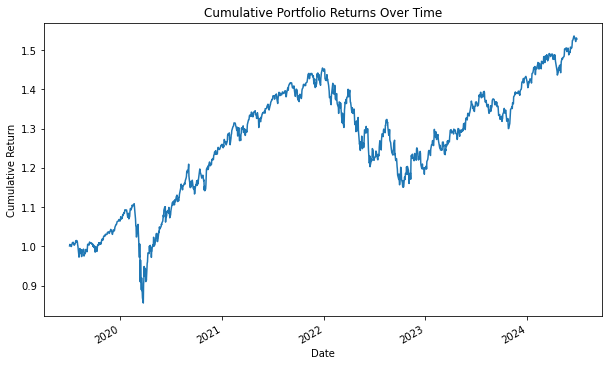

In [209]:
# Calculate the portfolio returns by multiplying the weights by the historical returns
backtest_portfolio_returns = historical_excess_returns.dot(benchmark_mvo_weights_formatted)


# Calculate cumulative returns over time
mvo_cumulative_returns = (1 + backtest_portfolio_returns).cumprod()

# Display the first few rows of cumulative returns
print(mvo_cumulative_returns.head())

# Optionally, plot the cumulative returns over time
mvo_cumulative_returns.plot(title='Cumulative Portfolio Returns Over Time', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()



The plot of the cumulative portfolio returns over time for the portfolio with posterior views and the same level of risk as the benchmark shows a generally upward trend, indicating that the portfolio has generated positive returns over the backtesting period. There are periods of volatility, with noticeable dips during market downturns, but the portfolio demonstrates resilience by recovering and continuing its upward trajectory. The overall growth in the cumulative returns suggests that the portfolio has been successful in capturing market gains while managing risk, as it closely aligns with the target risk level of the benchmark. 

Lets now look how it performs vs other portfolios.

In [210]:
# Convert the DataFrames to Series if necessary
msr_weights = msr_df.set_index('Asset')['Weight']
gmv_weights = gmv_df.set_index('Asset')['Weight']

In [211]:
# Adding an equally weighted portfolio
equal_weights = pd.Series(1 / len(historical_excess_returns.columns), index=historical_excess_returns.columns)

# Creating a new dictionary for the portfolios
portfolio_strat = {}

# Adding the equally weighted portfolio to the portfolios dictionary
portfolio_strat['Equally Weighted Portfolio'] = equal_weights

In [212]:
# Adding Market Weights for backtesting
portfolio_strat.update({
    'MVO Strategy': benchmark_mvo_weights_formatted,
    'MSR Portfolio': msr_weights,
    'GMV Portfolio': gmv_weights,
    'Market/Benchmark Portfolio': market_weights
})


            Equally Weighted Portfolio  MVO Strategy  MSR Portfolio  \
Date                                                                  
2019-07-02                    1.000635      1.001459       1.001440   
2019-07-03                    1.004647      1.005335       1.006215   
2019-07-05                    1.001812      1.003981       1.004490   
2019-07-08                    0.997716      0.999813       0.999147   
2019-07-09                    0.997246      1.000927       1.001040   

            GMV Portfolio  Market/Benchmark Portfolio  
Date                                                   
2019-07-02       1.000521                    1.000784  
2019-07-03       1.001314                    1.005086  
2019-07-05       0.999618                    1.001976  
2019-07-08       0.999358                    0.997461  
2019-07-09       0.999017                    0.996791  


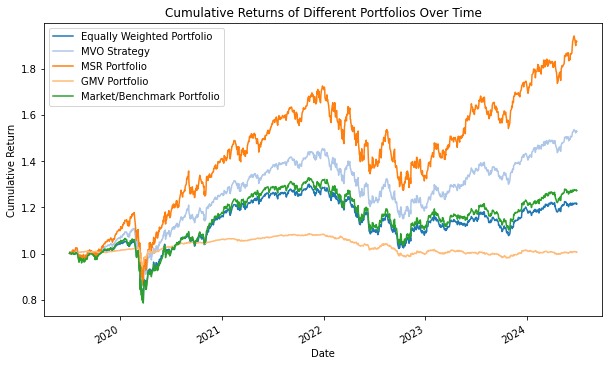

In [213]:
# Backtesting each portfolio
backtest_results = {}

for name, weights in portfolio_strat.items():
    portfolio_returns = historical_excess_returns.dot(weights)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    backtest_results[name] = cumulative_returns

# Convert the backtest results to a DataFrame for easier comparison
backtest_df = pd.DataFrame(backtest_results)

# Display the backtest results
print(backtest_df.head())

# Optionally, plot the cumulative returns for all portfolios
backtest_df.plot(title='Cumulative Returns of Different Portfolios Over Time', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left')
plt.show()

The chart illustrates the cumulative returns of different portfolios over time, comparing the performance of the Mean-Variance Optimized (MVO) Strategy, Maximum Sharpe Ratio (MSR) Portfolio, Global Minimum Variance (GMV) Portfolio, Market/Benchmark Portfolio, and an Equally Weighted Portfolio.

Key observations include:

- MVO Strategy: The MVO strategy with the same level of risk as the benchmark has significantly outperformed the Market/Benchmark Portfolio over the entire period. This suggests that optimizing the portfolio based on the posterior returns and covariance matrix has effectively captured higher returns while maintaining the same risk level, validating the efficacy of incorporating views into the Black-Litterman framework.

- MSR Portfolio: The Maximum Sharpe Ratio Portfolio had the highest returns. This indicates that a focus on maximizing risk-adjusted returns.

GMV Portfolio: The Global Minimum Variance Portfolio, designed to minimize risk, understandably shows the lowest returns among the strategies but maintains a very stable growth path, which is expected due to its conservative nature. It is essentially flat over the timeframe which makes sense as these are excess returns over the rf rate.

Market/Benchmark Portfolio: The Market/Benchmark Portfolio, representing the original asset allocation without optimization, has underperformed compared to the MVO Strategy. This underperformance highlights the value added by optimization, particularly when aligning portfolio allocations with updated expectations from the Black-Litterman model.

Equally Weighted Portfolio: The Equally Weighted Portfolio shows moderate performance, underlining the risks of not considering the specific characteristics or expected returns of individual assets.

Overall, the MVO strategy's superior performance demonstrates the benefits of optimizing portfolio weights using the Black-Litterman model's posterior inputs, especially in capturing higher returns for the same level of risk as the market benchmark. This reinforces the potential advantages of incorporating informed views into the portfolio construction process.

In [214]:
# Function to calculate annualized return
def annualized_return(cumulative_returns):
    n_periods = len(cumulative_returns)
    return (cumulative_returns.iloc[-1])**(252/n_periods) - 1

# Function to calculate annualized risk (volatility)
def annualized_risk(returns):
    return returns.std() * np.sqrt(252)

# Function to calculate Sharpe ratio
def sharpe_ratio(returns, annual_return, annual_risk):
    return (annual_return - 0) / annual_risk

# DataFrame to store the results
metrics_df = pd.DataFrame(columns=['Annualized Return', 'Annualized Risk', 'Sharpe Ratio'])

# Calculate metrics for each portfolio
for name, cumulative_returns in backtest_df.items():
    # Daily returns for the portfolio
    portfolio_returns = cumulative_returns.pct_change().dropna()
    
    # Calculate annualized return
    ann_return = annualized_return(cumulative_returns)
    
    # Calculate annualized risk
    ann_risk = annualized_risk(portfolio_returns)
    
    # Calculate Sharpe ratio
    sharpe = sharpe_ratio(portfolio_returns, ann_return, ann_risk)
    
    # Store the results in the DataFrame
    metrics_df.loc[name] = [ann_return, ann_risk, sharpe]

# Display the metrics DataFrame
metrics_df


,Annualized Return,Annualized Risk,Sharpe Ratio
Equally Weighted Portfolio,0.039765,0.126755,0.313716
MVO Strategy,0.088667,0.140960,0.629024
MSR Portfolio,0.139312,0.191699,0.726726
GMV Portfolio,0.001160,0.035845,0.032356
Market/Benchmark Portfolio,0.049450,0.141006,0.350691


The table highlights the performance of different portfolio strategies:

- MVO Strategy: Achieved an 8.87% annualized return with 14.10% risk and a Sharpe Ratio of 0.629, outperforming the Market/Benchmark Portfolio with similar risk but better returns.

- MSR Portfolio: Highest return (13.93%) and risk (19.17%) with the best Sharpe Ratio (0.727), maximizing risk-adjusted returns.

- GMV Portfolio: Very low return (0.12%) and risk (3.58%), with a minimal Sharpe Ratio (0.032), focusing on minimizing risk.

- Market/Benchmark Portfolio: Moderate return (4.95%) and risk, with a Sharpe Ratio of 0.351, lagging behind optimized strategies.

- Equally Weighted Portfolio: Lower return (3.98%) and risk (12.68%), with a Sharpe Ratio of 0.314, less efficient compared to optimized strategies.

In summary, the MVO Strategy offers a good risk-return balance, while the MSR Portfolio excels in returns but at higher risk.

#### Factor Exposure

Let us now see if the views we have made and applied to the portfolios have resulted in higher exposure to certain risk factors. Based on our factor anaysis at the begining we wanted to increase our exposure to Growth and Size.

In [215]:
#Test to see if our views have been reflected in higher exposures
X = combined_data[['Mkt-RF', 'SMB', 'HML']]  # Independent variables (Fama-French factors)
y = backtest_portfolio_returns  # Dependent variable (Mean Variance Optimized Portfolio)

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
mvo_model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(mvo_model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     7678.
Date:                Thu, 22 Aug 2024   Prob (F-statistic):               0.00
Time:                        20:36:54   Log-Likelihood:                 6018.6
No. Observations:                1257   AIC:                        -1.203e+04
Df Residuals:                    1253   BIC:                        -1.201e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.896e-05    5.7e-05      0.508      0.6

c:\Users\kiera\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


The OLS regression results provide insights into how the Mean Variance Optimized (MVO) portfolio is exposed to various risk factors based on the Fama-French model:

Mkt-RF (Market Risk Premium): The coefficient for the market risk premium is 0.695, which is highly significant (p-value = 0.000). This indicates that the MVO portfolio has a strong positive exposure to the overall market, meaning it generally moves with market trends.

SMB (Small Minus Big): The coefficient for SMB is -0.3316, and it is also highly significant (p-value = 0.000). This negative value indicates that the MVO portfolio is more heavily weighted toward large-cap stocks, as opposed to small-cap stocks. This aligns with your anticipation of increased exposure to larger companies.

HML (High Minus Low, or Value vs. Growth): The coefficient for HML is -0.1758, and it is highly significant (p-value = 0.000). A negative coefficient here suggests that the portfolio has a tilt towards growth stocks as opposed to value stocks, which also aligns with your expectations.

Overall, these results suggest that the MVO portfolio has achieved the intended exposure towards large-cap and growth stocks, reflecting the views that were implemented during the portfolio construction process. The high R-squared value of 0.948 indicates that the model explains a substantial portion of the variability in portfolio returns, making these findings robust.

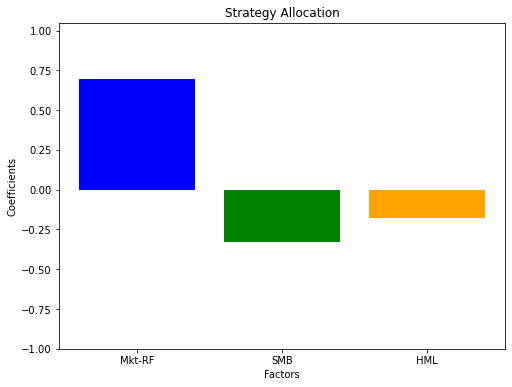

In [216]:
coefficients = mvo_model.params[1:]  # Exclude the intercept (constant)
factors = ['Mkt-RF', 'SMB', 'HML']  # Ensure these are in the same order as in the model

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(factors, coefficients, color=['blue', 'green', 'orange'])
plt.xlabel('Factors')
plt.ylabel('Coefficients')
plt.title('Strategy Allocation')
plt.ylim(-1, 1.05)  # Set limits to make the graph more readable

# Display the plot
plt.show()

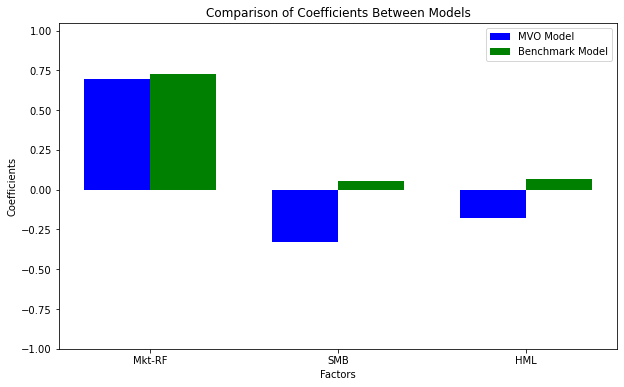

In [217]:
import numpy as np

coefficients1 = mvo_model.params[1:]  # From the first model
coefficients2 = model_benchmark.params[1:]  # From the second model
factors = ['Mkt-RF', 'SMB', 'HML']

# Set up the bar width and position
bar_width = 0.35
index = np.arange(len(factors))

# Create a combined bar chart
plt.figure(figsize=(10, 6))
plt.bar(index, coefficients1, bar_width, color='blue', label='MVO Model')
plt.bar(index + bar_width, coefficients2, bar_width, color='green', label='Benchmark Model')

# Labeling the axes and the chart
plt.xlabel('Factors')
plt.ylabel('Coefficients')
plt.title('Comparison of Coefficients Between Models')
plt.xticks(index + bar_width / 2, factors)
plt.ylim(-1, 1.05)  # Set limits to make the graph more readable

# Adding a legend
plt.legend()

# Display the plot
plt.show()


The chart compares the factor exposures between the Mean Variance Optimized (MVO) model and the Benchmark model across three Fama-French factors: Market (Mkt-RF), Size (SMB), and Value (HML).

- Market (Mkt-RF): Both models have similar high exposure to the market factor, indicating that both portfolios are highly correlated with overall market movements.

- Size (SMB): The MVO model shows a significantly more negative coefficient compared to the Benchmark model, highlighting a stronger tilt towards large-cap stocks. This is consistent with the objective of increasing exposure to larger companies.

- Value (HML): The MVO model has a more negative coefficient than the Benchmark model, indicating a greater tilt towards growth stocks over value stocks. This reflects the intended view of favoring growth-oriented investments.

Overall, the chart effectively demonstrates that the MVO strategy has successfully increased exposure to large-cap and growth stocks compared to the benchmark portfolio, aligning with the views implemented during the portfolio construction.

# 8. Conclusion

In this paper, we undertook a comprehensive process to construct and optimize an investment portfolio, leveraging advanced quantitative methods and informed by both market data and theoretical models. Our journey began with the careful selection of a benchmark and a diverse set of assets that provided broad exposure across various sectors and asset classes. The benchmark, chosen to represent a well-diversified market portfolio, included a mix of equity, fixed income, and sector-specific ETFs, providing a robust foundation for our subsequent analysis. 

We then conducted an in-depth Fama-French three-factor analysis, incorporating the Market (Mkt-RF), Size (SMB), and Value (HML) factors, along with a momentum factor analysis. These analyses provided critical insights into the risk factors driving asset returns, revealing notable trends such as a tilt towards large-cap and growth stocks, which became the basis for the views we later implemented in the Black-Litterman model.

The Black-Litterman model served as the centerpiece of our portfolio construction process. By integrating our market views—derived from the factor and momentum analyses—into the model, we were able to adjust the implied equilibrium returns to reflect our expectations. This allowed us to create a set of posterior returns that better aligned with our strategic views, such as an increased exposure to growth and large-cap stocks.

Following the creation of the Black-Litterman model, we employed various optimization techniques to construct portfolios with different objectives. These included the Global Minimum Variance (GMV) portfolio, the Maximum Sharpe Ratio (MSR) portfolio, and the Mean-Variance Optimized (MVO) portfolio. Each of these optimization methods was tailored to balance risk and return, with specific constraints such as no shorting and a maximum asset allocation cap to ensure practical applicability.

Finally, we backtested our optimized portfolios to evaluate their performance over time. The results were compelling—our MVO strategy, which maintained the same level of risk as the benchmark, significantly outperformed the benchmark portfolio. This superior performance, reflected in higher cumulative returns and a better Sharpe ratio, demonstrated the effectiveness of our approach. The strategic tilts towards growth and large-cap stocks, implemented through the Black-Litterman model and optimized using advanced techniques, successfully enhanced the portfolio's return without increasing risk.

To further enhance our analysis, we could expand our asset universe to include alternative investments like commodities and private assets, providing greater diversification and reducing portfolio risk. Additionally, incorporating dynamic factor models  or newer factors into our factor analysis would allow us to better capture changing market conditions over time, improving our understanding of return drivers. Lastly, refining our Black-Litterman model by implementing dynamic views that adjust based on new market information would make our portfolio strategy more responsive and adaptable to evolving market conditions.

In conclusion, this paper showcases the power of integrating theoretical models with empirical data in portfolio construction. By methodically applying the Black-Litterman model, informed by factor and momentum analyses, and optimizing the portfolio with sophisticated techniques, we were able to create a strategy that not only met but exceeded the performance of the benchmark portfolio. This approach underscores the value of combining rigorous quantitative methods with informed market views to achieve superior investment outcomes.

# References :

1. Black, F., & Litterman, R. (1992). Global portfolio optimization. Financial Analysts Journal,
2. Fama, E. F., & French, K. R. (1993). Common risk factors in the returns on stocks and bonds. Journal of Financial Economics
3. Markowitz, H. (1952). Portfolio Selection. The Journal of Finance
4. State Street Global Advisors (n.d.). SPDR SSgA Global Allocation ETF (GALl)
5. da Silva, A. S., Lee, W., & Pornrojnangkool, T. (2009). The Black-Litterman Model for Active Portfolio Management. Journal of Portfolio Management,
6. Idzorek, T. M. (2004). A Step-by-Step Guide to the Black-Litterman Model: Incorporating User-Specified Confidence Levels. 
7. Carhart, M. M. (1997). On Persistence in Mutual Fund Performance. The Journal of Finance
8. Fanyu Zhao (2023), PORTFOLIO CONSTRUCTION USING BLACK-LITTERMAN MODELAND FACTORS
9. CQF Slides " Portfolio Construction with Views"

In [218]:
methods = {
    "Methods Implemented": [
        "Portfolio Optimisation Techniques",
        "Portfolio Optimisation and Plotting",
        "Black-Litterman Construction",
        "Bootstrapped Fama-French Regression"
    ],
    "Method Adaption": [
        "CQF Labs",
        "PyPortfolioOpt",
        "Edhec Portfolio Construction",
        "Georgi Dragomanov (Kaggle)"
    ]
}

# Creating the DataFrame
_df = pd.DataFrame(methods)

# Displaying the DataFrame
_df


,Methods Implemented,Method Adaption
0,Portfolio Optimisation Techniques,CQF Labs
1,Portfolio Optimisation and Plotting,PyPortfolioOpt
2,Black-Litterman Construction,Edhec Portfolio Construction
3,Bootstrapped Fama-French Regression,Georgi Dragomanov (Kaggle)
